<a target="_blank" href="https://colab.research.google.com/github/SayakMukherjee/PhD_GuidedDiff/blob/main/BoN/gmm2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import copy
import torch
import warnings
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn.functional as F

from pathlib import Path
from tqdm.auto import tqdm
from torchvision import transforms
from sklearn.manifold import TSNE
# from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')


/glb/data/ptxd_dash/nlasqh/anaconda3/envs/ldm3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
set_seed(2024)

Random seed 2024 has been set.


In [4]:
OUTPUTS_DIR = 'outputs_toy_final'

if not Path.exists(Path(OUTPUTS_DIR)):
    Path.mkdir(Path(OUTPUTS_DIR), exist_ok=True, parents=True)

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

## Gaussian Mixture Class

In [5]:
class GaussianMixture:

  def __init__(self, mus, covs, weights, device='cuda'):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.a = covs
    self.device = device
    self.precs = [torch.from_numpy(np.linalg.inv((cov * torch.eye(2).cuda()).cpu().numpy())).to(cov.device) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(D.Independent(D.Normal(mus[i], covs[i]), 1))
    self.dim = len(mus[0])

  def compute_mean(self):

    mu_bar = 0.0
    for weight, mu in zip(self.norm_weights, self.mus):
      mu_bar += weight * mu

    return mu_bar

  def compute_variance(self):

    mu_bar = self.compute_mean()
    var = None
    for weight, mu, cov in zip(self.norm_weights, self.mus, self.covs):

      assert cov[0] == cov[1]

      covmat = cov[0]**2 * torch.eye(2).to(cov.device)

      temp = weight * (covmat + torch.mm((mu - mu_bar).unsqueeze(0).T, (mu - mu_bar).unsqueeze(0)))
      var = temp if var is None else var + temp

    return var

  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov.cpu().numpy()))
    self.RVs.append(D.Independent(D.Normal(mu, cov), 1))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1

  def pdf_decompose(self, x):
    """
      probability density (PDF) at $x$.
    """
    component_pdf = []
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.log_prob(x).exp()
        prob = pdf if prob is None else (prob + pdf)
        component_pdf.append(pdf)
    component_pdf = np.array(component_pdf)
    return prob, component_pdf

  def pdf(self, x):
    """
      probability density (PDF) at $x$.
    """
    isnumpy = False
    if type(x) is np.ndarray:
      isnumpy = True
      x = torch.from_numpy(x).to(self.mus[0].device)

    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.log_prob(x).exp()
        prob = pdf if prob is None else (prob + pdf)

    if isnumpy:
      prob = prob.cpu().numpy()

    return prob
  
  def scaled_pdf(self, x, scale):
    """
      probability density (PDF) at $x$.
    """
    isnumpy = False
    if type(x) is np.ndarray:
      isnumpy = True
      x = torch.from_numpy(x).to(self.mus[0].device)

    scale = torch.tensor(scale).to(self.mus[0].device)
    scale = torch.sqrt(scale)

    scaled_x = scale * x
    prob = None
    for idx in range(self.n_component):
      component = D.Independent(D.Normal(scale * self.mus[idx], self.a[idx]), 1)
      pdf = self.norm_weights[idx] * component.log_prob(scaled_x).exp()
      prob = pdf if prob is None else (prob + pdf)

    # for weight, RV in zip(self.norm_weights, self.RVs):
    #     pdf = weight * RV.log_prob(x).exp()
    #     prob = pdf if prob is None else (prob + pdf)

    if isnumpy:
      prob = prob.cpu().numpy()

    return prob

  def score(self, x):
    """
    Compute the score $\nabla_x \log p(x)$ for the given $x$.
    """
    isnumpy = False
    if type(x) is np.ndarray:
      isnumpy = True
      x = torch.from_numpy(x).to(torch.float).to(self.mus[0].device)

    component_pdf = np.array([rv.log_prob(x).exp().cpu().numpy() for rv in self.RVs])
    component_pdf = torch.from_numpy(component_pdf).T

    # if isnumpy:
    #   component_pdf = np.array([rv.log_prob(x).exp().cpu().numpy() for rv in self.RVs]).T
    # else:
    #   component_pdf = np.array([rv.log_prob(x).exp() for rv in self.RVs]).T

    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)
    participance = participance.to(self.mus[0].device)

    scores = torch.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec

    if isnumpy:
      scores = scores.cpu().numpy()

    return scores

  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.log_prob(x).exp() for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
      # scores += participance[:, i:i+1] * gradvec

    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.sample((N,)).cpu().numpy() for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

In [6]:
# Gaussian mixture
mu1 = torch.tensor([2.0, 8.0]).to('cuda')
Cov1 = torch.tensor([1.0, 1.0]).to('cuda')

mu2 = torch.tensor([5.0, 2.0]).to('cuda')
Cov2 = torch.tensor([1.0, 1.0]).to('cuda')

mu3 = torch.tensor([8.0, 8.0]).to('cuda')
Cov3 = torch.tensor([1.0, 1.0]).to('cuda')

gmm = GaussianMixture([mu1, mu2, mu3],[Cov1, Cov2, Cov3], [1.0, 1.0, 1.0])

In [ ]:
def gmm_pdf_contour_plot(gmm, xlim=None,ylim=None,ticks=100,logprob=False,label=None,**kwargs):
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, ticks), np.linspace(*ylim, ticks))
    pdf = gmm.pdf(np.dstack((xx,yy)))
    if logprob:
        pdf = np.log(pdf)
    plt.contour(xx, yy, pdf, **kwargs,)

# @title Visualize log density
show_samples = True  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples, _, _ = gmm.sample(2000)
plt.figure(figsize=[8, 8])
plt.axis([0,10,0,10])
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
gmm_pdf_contour_plot(gmm, cmap="Greys", levels=20, logprob=True)
plt.title("log density of gaussian mixture $\log p(x)$")
# plt.axis("image")
plt.show()

In [ ]:
# @title Visualize Score
set_seed(2024)

basedist = D.Independent(D.Normal(torch.tensor([5.0, 6.0]), torch.ones(2)), 1)
gmm_samps_few, _, _ = gmm.sample(300)
gmm_samps_few = np.concatenate([gmm_samps_few, basedist.sample((100,)).cpu().numpy()], axis=0)
scorevecs_few = gmm.score(gmm_samps_few)
# gradvec_list, participance = gmm.score_decompose(gmm_samps_few)

In [ ]:
def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)

# @title Score for Gaussian mixture
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, scorevecs_few,
            color="black", scale=25, alpha=0.7, width=0.003,
            label="score of GMM")
gmm_pdf_contour_plot(gmm, cmap="Greys")
plt.title("Score vector field $\\nabla\log p(x)$ for Gaussian Mixture")
plt.axis("image")
plt.legend()
plt.show()

## Scenarios - Gaussian

In [ ]:
# @title Base Distribution
mu_b = torch.tensor([5.0, 5.0]).to('cuda')
Cov_b = torch.tensor([3.0, 3.0]).to('cuda')

gmm_b = GaussianMixture([mu_b],[Cov_b], [1.0])

# @title Visualize log density
show_samples = False  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples, _, _ = gmm_b.sample(2000)
fig, ax = plt.subplots(figsize=[5, 5])
plt.axis([0,10,0,10])
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
# gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# plt.title("log density of gaussian mixture $\log p(x)$")
sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax, cmap='Blues')
plt.show()

In [ ]:
# @title Reward Distribution: Subset of base

mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])


show_samples = False  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples_r1, _, _ = gmm_r1.sample(2000)
fig, ax = plt.subplots(figsize=[5, 5])
plt.axis([0,10,0,10])
plt.scatter(gmm_samples_r1[:, 0],
            gmm_samples_r1[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
# gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# plt.title("log density of gaussian mixture $\log p(x)$")
sns.kdeplot(x=gmm_samples_r1[:,0], y=gmm_samples_r1[:,1], fill=True, ax=ax, cmap='Blues')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=[15, 5])

sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax[0], cmap='Blues')
ax[0].axis([0,10,0,10])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Prior: Original Diffusion Model\n' + r'$p(x)$', y=-0.15)

sns.kdeplot(x=gmm_samples_r1[:,0], y=gmm_samples_r1[:,1], fill=True, ax=ax[1], cmap='Blues')
ax[1].axis([0,10,0,10])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Evidence: Reward Model\n' + r'$exp(r(x))$', y=-0.15)

gmm_samples_overall = np.concatenate([gmm_samples_r1[:800, :], gmm_samples])

sns.kdeplot(x=gmm_samples_overall[:,0], y=gmm_samples_overall[:,1], fill=True, ax=ax[2], cmap='Blues')
ax[2].axis([0,10,0,10])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Posterior: Aligned Diffusion Model\n' + r'$p^*(x) \propto p(x)exp(r(x))$', y=-0.15)

plt.tight_layout()
# plt.show()
plt.savefig(f'{OUTPUTS_DIR}/subspace.png', dpi=300)

In [ ]:
# @title Reward Distribution: Out-of-distristribution

mu_r2 = torch.tensor([9.0, 9.0]).to('cuda')
# Cov_r2 = torch.tensor([1.0, 1.0]).to('cuda')
Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])


show_samples = False  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples_r2, _, _ = gmm_r2.sample(2000)
fig, ax = plt.subplots(figsize=[5, 5])
plt.axis([0,10,0,10])
plt.scatter(gmm_samples_r2[:, 0],
            gmm_samples_r2[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
# gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# plt.title("log density of gaussian mixture $\log p(x)$")
sns.kdeplot(x=gmm_samples_r2[:,0], y=gmm_samples_r2[:,1], fill=True, ax=ax, cmap='Blues')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=[15, 5])

sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax[0], cmap='Blues')
ax[0].axis([0,10,0,10])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Prior: Original Diffusion Model\n' + r'$p(x)$', y=-0.15)

sns.kdeplot(x=gmm_samples_r2[:,0], y=gmm_samples_r2[:,1], fill=True, ax=ax[1], cmap='Blues')
ax[1].axis([0,10,0,10])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Evidence: Reward Model\n' + r'$exp(r(x))$', y=-0.15)

gmm_samples_overall = np.concatenate([gmm_samples_r2[:2000, :], gmm_samples])

sns.kdeplot(x=gmm_samples_overall[:,0], y=gmm_samples_overall[:,1], fill=True, ax=ax[2], cmap='Blues')
ax[2].axis([0,10,0,10])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Posterior: Aligned Diffusion Model\n' + r'$p^*(x) \propto p(x)exp(r(x))$', y=-0.15)

plt.tight_layout()
# plt.show()
plt.savefig(f'{OUTPUTS_DIR}/OOD.png', dpi=300)

## Scenarios - Gaussian Mixture Model

In [6]:
# @title Base Distribution
mu_b_1 = torch.tensor([5.0, 3.0]).to('cuda')
Cov_b_1 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_2 = torch.tensor([3.0, 7.0]).to('cuda')
Cov_b_2 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_3 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_b_3 = torch.tensor([2.0, 2.0]).to('cuda')

gmm_b = GaussianMixture([mu_b_1, mu_b_2, mu_b_3],[Cov_b_1, Cov_b_2, Cov_b_3], [1.0, 1.0, 1.0])

# @title Visualize log density
# show_samples = False  # @param {type:"boolean"}
# np.random.seed(42)
# gmm_samples, _, _ = gmm_b.sample(2000)
# fig, ax = plt.subplots(figsize=[5, 5])
# plt.axis([0,10,0,10])
# plt.scatter(gmm_samples[:, 0],
#             gmm_samples[:, 1],
#             s=10,
#             alpha=0.4 if show_samples else 0.0)
# # gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# # plt.title("log density of gaussian mixture $\log p(x)$")
# sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax, cmap='Blues')
# plt.show()

In [7]:
# @title Reward Distribution: Subset of base

mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

# mu_r1 = torch.tensor([3.0, 7.0]).to('cuda')
# Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

# mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
# Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')


gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])


# show_samples = False  # @param {type:"boolean"}
# np.random.seed(42)
# gmm_samples_r1, _, _ = gmm_r1.sample(2000)
# fig, ax = plt.subplots(figsize=[5, 5])
# plt.axis([0,10,0,10])
# plt.scatter(gmm_samples_r1[:, 0],
#             gmm_samples_r1[:, 1],
#             s=10,
#             alpha=0.4 if show_samples else 0.0)
# # gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# # plt.title("log density of gaussian mixture $\log p(x)$")
# sns.kdeplot(x=gmm_samples_r1[:,0], y=gmm_samples_r1[:,1], fill=True, ax=ax, cmap='Blues')
# plt.show()

In [9]:
def z_func(x, y, func, scale=None):
    h, w = x.shape
    x_flat = x.reshape(-1)
    y_flat = y.reshape(-1)
    x1 = np.column_stack((y_flat, x_flat))

    if scale is None:
        results = np.apply_along_axis(func, 1, x1)
    else:
        results = np.apply_along_axis(func, 1, x1, scale=scale)
        
    return results.reshape(h,w).T

def posterior(x, scale):
    return gmm_b.pdf(x) * gmm_r1.scaled_pdf(x, scale=scale)

# x = np.arange(15.5, -6, -0.1) # -5, 15
x = np.arange(-5, 16.5, 0.1)
y = np.arange(-5, 16.5, 0.1)
X,Y = np.meshgrid(x, y) # grid of point

In [ ]:
fig, ax = plt.subplots(1,2,figsize=[15, 5])

scale_factor = 0.1

# prior = gmm_b.pdf(gmm_samples)
# sns.scatterplot(x=gmm_samples[:,0], y=gmm_samples[:,1], ax=ax[0], hue=prior, legend=False)
# sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax[0], cmap='Blues')
# ax[0].axis([-2.5,12.5,-2.5,12.5])

# out_b = z_func(X, Y, gmm_b.pdf)
# sns.heatmap(out, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), ax=ax[0], vmax=np.max(out), vmin=np.min(out), cbar=True, label=r'$p(x)$')
# ax[0].set_xticks(ticks=np.arange(0, 150, 15), labels=np.arange(-2.5, 12.5, 1.5), rotation=0)
# ax[0].set_yticks(ticks=np.arange(0, 150, 15), labels=np.arange(11.5, -3.5, -1.5), rotation=0)
ax[0].contour(X,Y,out_b, label=r'$p(x)$', cmap='Blues')
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# ax[0].set_title('Prior: Original Diffusion Model\n' + r'$p(x)$', y=-0.3, fontsize=16)

# # evidence = gmm_r1.scaled_pdf(gmm_samples_r1, scale=scale_factor)
# # sns.scatterplot(x=gmm_samples_r1[:,0], y=gmm_samples_r1[:,1], ax=ax[1], hue=evidence, legend=False)
# # # sns.kdeplot(x=gmm_samples_r1[:,0], y=gmm_samples_r1[:,1], fill=True, ax=ax[1], cmap='Blues')
# # ax[1].axis([-2.5,12.5,-2.5,12.5])

# out_pr = z_func(X, Y, gmm_r1.pdf)
# sns.heatmap(out, cmap="ch:s=-.2,r=.6", ax=ax[1], vmax=np.max(out), vmin=np.min(out), cbar=False, label=r'$exp(r(x))$', alpha=0.6)
# # ax[1].set_xticks(ticks=np.arange(0, 150, 15), labels=np.arange(-2.5, 12.5, 1.5), rotation=0)
# # ax[1].set_yticks(ticks=np.arange(0, 150, 15), labels=np.arange(11.5, -3.5, -1.5), rotation=0)
ax[0].contour(X,Y,out_pr, label=r'$exp(r(x))$', cmap='Reds')
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# ax[1].set_title('Evidence: Reward Model\n' + r'$exp(r(x))$', y=-0.3, fontsize=16)

# # # gmm_samples_overall = np.concatenate([gmm_samples_r1[:800, :], gmm_samples])
# # # sns.kdeplot(x=gmm_samples_overall[:,0], y=gmm_samples_overall[:,1], fill=True, ax=ax[2], cmap='Blues')
# # posterior = prior * gmm_r1.scaled_pdf(gmm_samples, scale=scale_factor)
# # posterior /= np.sum(posterior)
# # sns.scatterplot(x=gmm_samples[:,0], y=gmm_samples[:,1], ax=ax[2], hue=posterior, legend=False)
# # # sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax[2], cmap='Blues', weights=posterior)
# # ax[2].axis([-2.5,12.5,-2.5,12.5])

# out_post = z_func(X, Y, posterior, scale=scale_factor)
# out_post /= np.sum(out_post)
ax[1].contour(X,Y,out_post, label=r'$p^*(x) \propto p(x)exp(r(x))$', cmap='Blues')
# sns.heatmap(out, cmap="ch:s=-.2,r=.6", ax=ax[2], vmax=np.max(out), vmin=np.min(out), cbar=False)
# # ax[2].set_xticks(ticks=np.arange(0, 150, 15), labels=np.arange(-2.5, 12.5, 1.5), rotation=0)
# # ax[2].set_yticks(ticks=np.arange(0, 150, 15), labels=np.arange(11.5, -3.5, -1.5), rotation=0)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# ax[2].set_title('Posterior: Aligned Diffusion Model\n' + r'$p^*(x) \propto p(x)exp(r(x))$', y=-0.3, fontsize=16)

ax[1].legend()
plt.tight_layout()
plt.show()
# plt.savefig(f'{OUTPUTS_DIR}/sc1.png', dpi=300)

In [32]:
# @title Reward Distribution: Out-of-distristribution

mu_r2 = torch.tensor([14.0, 3.0]).to('cuda')
# Cov_r2 = torch.tensor([1.0, 1.0]).to('cuda')
Cov_r2 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])

# show_samples = False  # @param {type:"boolean"}
# np.random.seed(42)
# gmm_samples_r2, _, _ = gmm_r2.sample(2000)
# fig, ax = plt.subplots(figsize=[5, 5])
# plt.axis([0,20,0,20])
# plt.scatter(gmm_samples_r2[:, 0],
#             gmm_samples_r2[:, 1],
#             s=10,
#             alpha=0.4 if show_samples else 0.0)
# # gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# # plt.title("log density of gaussian mixture $\log p(x)$")
# sns.kdeplot(x=gmm_samples_r2[:,0], y=gmm_samples_r2[:,1], fill=True, ax=ax, cmap='Blues')
# plt.show()

In [33]:
def z_func(x, y, func, scale=None):
    h, w = x.shape
    x_flat = x.reshape(-1)
    y_flat = y.reshape(-1)
    x1 = np.column_stack((y_flat, x_flat))

    if scale is None:
        results = np.apply_along_axis(func, 1, x1)
    else:
        results = np.apply_along_axis(func, 1, x1, scale=scale)
        
    return results.reshape(h,w).T

def posterior(x, scale):
    return gmm_b.pdf(x) * gmm_r2.scaled_pdf(x, scale=scale)

x = np.arange(15.5, -6, -0.1) # -5, 15
y = np.arange(-5, 16.5, 0.1)
X,Y = np.meshgrid(x, y) # grid of point

In [ ]:
fig, ax = plt.subplots(1,3,figsize=[15, 5])

# sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax[0], cmap='Blues')
# # ax[0].axis([0,10,0,10])
# ax[0].axis([-2.5,12.5,-2.5,12.5])
# ax[0].set_xticks([])
# ax[0].set_yticks([])

out = z_func(X, Y, gmm_b.pdf)
sns.heatmap(out, cmap="Blues", ax=ax[0], vmax=np.max(out), vmin=np.min(out), cbar=False)
# ax[0].set_xticks(ticks=np.arange(0, 180, 15), labels=np.arange(-2.5, 15.5, 1.5), rotation=0)
# ax[0].set_yticks(ticks=np.arange(0, 180, 15), labels=np.arange(14.5, -3.5, -1.5), rotation=0)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Prior: Original Diffusion Model\n' + r'$p(x)$', y=-0.3, fontsize=16)

# # sns.kdeplot(x=gmm_samples_r2[:,0], y=gmm_samples_r2[:,1], fill=True, ax=ax[1], cmap='Blues')
# # ax[1].axis([-2.5,12.5,-2.5,12.5])

out = z_func(X, Y, gmm_r2.pdf)
sns.heatmap(out, cmap="Blues", ax=ax[1], cbar=False, vmax=np.max(out), vmin=np.min(out))
# ax[1].set_xticks(ticks=np.arange(0, 180, 15), labels=np.arange(-2.5, 15.5, 1.5), rotation=0)
# ax[1].set_yticks(ticks=np.arange(0, 180, 15), labels=np.arange(14.5, -3.5, -1.5), rotation=0)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Evidence: Reward Model\n' + r'$exp(r(x))$', y=-0.3, fontsize=16)

# # gmm_samples_overall = np.concatenate([gmm_samples_r2[:2000, :], gmm_samples])
# # sns.kdeplot(x=gmm_samples_overall[:,0], y=gmm_samples_overall[:,1], fill=True, ax=ax[2], cmap='Blues')
# # ax[2].axis([-2.5,12.5,-2.5,12.5])

out = z_func(X, Y, posterior, scale=scale_factor)
out /= np.sum(out)
sns.heatmap(out, cmap="Blues", ax=ax[2], vmax=np.max(out), vmin=np.min(out), cbar=False)
# ax[2].set_xticks(ticks=np.arange(0, 180, 15), labels=np.arange(-2.5, 15.5, 1.5), rotation=0)
# ax[2].set_yticks(ticks=np.arange(0, 180, 15), labels=np.arange(14.5, -3.5, -1.5), rotation=0)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Posterior: Aligned Diffusion Model\n' + r'$p^*(x) \propto p(x)exp(r(x))$', y=-0.3, fontsize=16)

plt.tight_layout()
# plt.show()
plt.savefig(f'{OUTPUTS_DIR}/sc2.png', dpi=300)

In [ ]:
# @title Combined plots

from matplotlib.lines import Line2D

mu_b_1 = torch.tensor([5.0, 3.0]).to('cuda')
Cov_b_1 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_2 = torch.tensor([3.0, 7.0]).to('cuda')
Cov_b_2 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_3 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_b_3 = torch.tensor([2.0, 2.0]).to('cuda')

gmm_b = GaussianMixture([mu_b_1, mu_b_2, mu_b_3],[Cov_b_1, Cov_b_2, Cov_b_3], [1.0, 1.0, 1.0])


mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])

mu_r2 = torch.tensor([14.0, 3.0]).to('cuda')
Cov_r2 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])

def z_func(x, y, func, scale=None, posterior=None):
    h, w = x.shape
    x_flat = x.reshape(-1)
    y_flat = y.reshape(-1)
    x1 = np.column_stack((y_flat, x_flat))

    if scale is None:
        results = np.apply_along_axis(func, 1, x1)
    else:
        results = np.apply_along_axis(func, 1, x1, scale=scale, posterior=posterior)
        
    return results.reshape(h,w).T

def posterior(x, scale, posterior):
    return gmm_b.pdf(x) * posterior.scaled_pdf(x, scale=scale)

# x = np.arange(15.5, -6, -0.1) # -5, 15
x = np.arange(-5, 16.5, 0.1)
y = np.arange(-5, 16.5, 0.1)
X,Y = np.meshgrid(x, y) # grid of point

IS_OOD = True

fig, ax = plt.subplots(1,2,figsize=(10,5))

scale_factor = 0.1

out_b = z_func(X, Y, gmm_b.pdf)
cnt1 = ax[0].contour(X,Y,out_b, label=r'$p(x)$', cmap='Blues')

if not IS_OOD:
    out_pr1 = z_func(X, Y, gmm_r1.pdf)
    cnt2 = ax[0].contour(X,Y,out_pr1, label=r'$exp(r(x))$', cmap='Reds')
    ax[0].set_xticks(x[0::50])
    ax[0].set_yticks(y[0::50])
    # ax[0].set_xlabel('x1', fontsize=16)
    # ax[0].set_ylabel('x2', fontsize=16)
    # ax[0].set_title('(a)', y=-0.18, fontsize=24)

    out_post1 = z_func(X, Y, posterior, scale=scale_factor, posterior=gmm_r1)
    out_post1 /= np.sum(out_post1)
    cnt3 = ax[1].contour(X,Y,out_post1, label=r'$p^*(x) \propto p(x)exp(r(x))$', cmap='Greens')
    ax[1].set_xticks(x[0::50])
    ax[1].set_yticks(y[0::50])
    # ax[1].set_xlabel('x1', fontsize=16)
    # ax[1].set_ylabel('x2', fontsize=16)
    # ax[1].set_title('(b)', y=-0.18, fontsize=24)

else:
    out_pr2 = z_func(X, Y, gmm_r2.pdf)
    cnt2 = ax[0].contour(X,Y,out_pr2, label=r'$exp(r(x))$', cmap='Reds')
    ax[0].set_xticks(x[0::50])
    ax[0].set_yticks(y[0::50])
    # ax[0].set_xlabel('x1', fontsize=16)
    # ax[0].set_ylabel('x2', fontsize=16)
    # ax[0].set_title('(a)', y=-0.18, fontsize=24)

    out_post2 = z_func(X, Y, posterior, scale=scale_factor, posterior=gmm_r2)
    out_post2 /= np.sum(out_post2)
    cnt3 = ax[1].contour(X,Y,out_post2, label=r'$p^*(x) \propto p(x)exp(r(x))$', cmap='Greens')
    ax[1].set_xticks(x[0::50])
    ax[1].set_yticks(y[0::50])
    # ax[1].set_xlabel('x1', fontsize=16)
    # ax[1].set_ylabel('x2', fontsize=16)
    # ax[1].set_title('(b)', y=-0.18, fontsize=24)

# ax[2].contour(X,Y,out_b, label=r'$p(x)$', cmap='Blues')

# # out_pr2 = z_func(X, Y, gmm_r2.pdf)
# ax[2].contour(X,Y,out_pr2, label=r'$exp(r(x))$', cmap='Reds')
# ax[2].set_xticks(x[0::50])
# ax[2].set_yticks(y[0::50])
# ax[2].set_title('(c)', y=-0.18, fontsize=24)

# # out_post2 = z_func(X, Y, posterior, scale=scale_factor, posterior=gmm_r2)
# # out_post2 /= np.sum(out_post2)
# ax[3].contour(X,Y,out_post2, label=r'$p^*(x) \propto p(x)exp(r(x))$', cmap='Greens', fill=True)
# ax[3].set_xticks(x[0::50])
# ax[3].set_yticks(y[0::50])
# ax[3].set_title('(d)', y=-0.18, fontsize=24)

handles, labels = plt.gca().get_legend_handles_labels()

# # # multiple levels
# # levels = [0, 1, 2, 3]
# # cnt = plt.contour(x, y, f(X, Y), levels)
# artists, labels = cnt1.legend_elements()

# # custom_artists = [cnt1.legend_elements()[-1], cnt2.legend_elements()[-1], cnt3.legend_elements()[-1]]
# custom_labels = []
# for level, contour in zip([1], cnt1.collections):
#     print('here')
#     custom_labels.append(r'Prior: $p(x)$')
# for level, contour in zip([1], cnt2.collections):
#     custom_labels.append(r'Evidence: $exp(r(x))$')
# for level, contour in zip([1], cnt3.collections):
#     custom_labels.append(r'Posterior: $p^*(x) \propto p(x)exp(r(x))$')
# # plt.legend(artists, custom_labels, bbox_to_anchor=[1.01, 1], loc='upper left')

line_b = Line2D([0], [0], label=r'Prior: $p(x)$', color=cnt1.collections[8].get_edgecolor()[0], lw=2)
line_pr = Line2D([0], [0], label=r'Reward: $p(r|x)$', color=cnt2.collections[7].get_edgecolor()[0], lw=2)
line_post = Line2D([0], [0], label=r'Posterior: $p(x|r) \propto p(x)p(r|x)$', color=cnt3.collections[6].get_edgecolor()[0], lw=2)

handles.extend([line_b, line_pr, line_post])
fig.legend(handles=handles, bbox_to_anchor=(0.97, 1.09), ncols=3, fontsize=16, frameon=False)

# fig.legend(custom_artists, custom_labels, bbox_to_anchor=(0.852, 1.17), ncols=3, fontsize=24, frameon=False)

fig.tight_layout()
# plt.show()

fig.savefig(f'{OUTPUTS_DIR}/toysetup_{"sc1" if not IS_OOD else "sc2"}.png', dpi=300, bbox_inches='tight')

## Diffusion Setup

In [6]:
NUM_SAMPLES = 1000
RESAMPLE_NOISE = False # CAUTION: IT WILL OVERWRITE THE NOISE SAMPLES!!!!

if RESAMPLE_NOISE:
    print('Sampling noise')
    NOISE_SAMPLES = torch.randn(NUM_SAMPLES, 2)
    torch.save(NOISE_SAMPLES, f'{OUTPUTS_DIR}/noise.pt')
else:
    print('Loading noise samples')
    NOISE_SAMPLES = torch.load(f'{OUTPUTS_DIR}/noise.pt')

NOISE_SAMPLES = NOISE_SAMPLES.to(DEVICE)

Loading noise samples


In [7]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size)).to(x.device)
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x / self.size * self.scale
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1).float() / self.size)

    def __len__(self):
        return self.size


class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1) * 0

    def __len__(self):
        return 1


class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        elif type == "linear":
            self.layer = LinearEmbedding(size, **kwargs)
        elif type == "learnable":
            self.layer = LearnableEmbedding(size)
        elif type == "zero":
            self.layer = ZeroEmbedding()
        elif type == "identity":
            self.layer = IdentityEmbedding()
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def forward(self, x: torch.Tensor):
        return self.layer(x)
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0]).to(x.device)
        x2_emb = self.input_mlp2(x[:, 1]).to(x.device)
        t_emb = self.time_mlp(t).to(x.device)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

class Conditional_MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.class_mlp = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer) + len(self.class_mlp.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, y, t):
        # print(f'{x.shape} {y.shape} {t.shape}')
        x1_emb = self.input_mlp1(x[:, 0]).to(x.device)
        x2_emb = self.input_mlp2(x[:, 1]).to(x.device)
        t_emb = self.time_mlp(t).to(x.device)
        y_emb = self.class_mlp(y[:,0]).to(x.device)
        # print(f'{x1_emb.shape} {x2_emb.shape} {t_emb.shape} {y_emb.shape}')
        x = torch.cat((x1_emb, x2_emb, t_emb, y_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.sqrt_alphas =  self.alphas ** 0.5
        self.sqrt_betas = self.betas ** 0.5
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1).to(x_t.device)
        s2 = s2.reshape(-1, 1).to(x_t.device)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1).to(x_t.device)
        s2 = s2.reshape(-1, 1).to(x_t.device)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(model_output.device)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_original_sample, pred_prev_sample

    def step_wgrad(self, model_output, timestep, sample, grad, scale = 0.5):

        t = timestep

        ## Change
        res = (scale * self.sqrt_one_minus_alphas_cumprod[t] * grad.float())
        model_output = model_output - (scale * self.sqrt_one_minus_alphas_cumprod[t] * grad.float())

        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(model_output.device)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return res, pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1).to(x_start.device)
        s2 = s2.reshape(-1, 1).to(x_start.device)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps
# Define beta schedule
T = 1000
noise_scheduler = NoiseScheduler(
      num_timesteps=T,
      beta_schedule="linear")

def forward_diffusion_sample(x_0, t):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)

    return noise_scheduler.add_noise(x_0, noise, t)

## Benchmarking Utils

In [8]:
# @title Compute KL Divergence

def kl_mvn(m0, S0, m1, S1):
    """
    https://stackoverflow.com/questions/44549369/kullback-leibler-divergence-from-gaussian-pm-pv-to-gaussian-qm-qv
    The following function computes the KL-Divergence between any two
    multivariate normal distributions
    (no need for the covariance matrices to be diagonal)
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.
    - accepts stacks of means, but only one S0 and S1
    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| +
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    # 'diagonal' is [1, 2, 3, 4]
    tf.diag(diagonal) ==> [[1, 0, 0, 0]
                          [0, 2, 0, 0]
                          [0, 0, 3, 0]
                          [0, 0, 0, 4]]
    # See wikipedia on KL divergence special case.
    #KL = 0.5 * tf.reduce_sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=1)
                if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    try:
        iS1 = np.linalg.inv(S1)
    except:
        print(S1)
        print(np.linalg.det(S1))
        raise ValueError()

    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N)

In [9]:
# @title Compute MMD (maximum mean discrepancy)

import numpy as np
from sklearn import metrics


def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=0.1):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

In [10]:
# @title Calculate Frechet Distance (FD)

from scipy.linalg import sqrtm

# calculate frechet inception distance
def calculate_fid(mu1, sigma1, mu2, sigma2):

	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

	return fid

In [11]:
def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = np.log(gmm_p.pdf(X))
    log_q_X = np.log(gmm_q.pdf(X))
    return log_p_X.mean() - log_q_X.mean()

## Experiments - Gaussian

In [ ]:
# mu_b = torch.tensor([5.0, 5.0]).to('cuda')
# Cov_b = torch.tensor([1.5, 1.5]).to('cuda')

# gmm_b = GaussianMixture([mu_b],[Cov_b], [1.0])

LOAD_DATA_FROM_FILE = True

if LOAD_DATA_FROM_FILE:
    dataX = np.load(f'{OUTPUTS_DIR}/dataX_newset.npy')
else:
    cov = np.array([[3, 0], [0, 3]])

    dataX = np.random.multivariate_normal([5.0, 5.0], cov, size=3000)

    np.save(f'{OUTPUTS_DIR}/dataX_newset.npy', dataX)

fig, ax = plt.subplots()

# sns.scatterplot(x=dataX[:,0], y=dataX[:,1], hue=dataY.reshape(-1), ax=ax)

g = sns.kdeplot(x=dataX[:,0], y=dataX[:,1], fill=True, ax = ax, cmap="Blues")

ax.axis([0, 10 ,0, 10])
ax.grid()

plt.show()

In [ ]:
data_x = torch.from_numpy(dataX.astype(np.float32))

simpledataset = TensorDataset(data_x) # create your datset
dataloader = DataLoader(simpledataset, shuffle=True, batch_size=32) # create your dataloader
model = MLP(
        hidden_size=128,
        hidden_layers=3,
        emb_size=128,
        time_emb="sinusoidal",
        input_emb="identity")

optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
    )

num_epochs = 200

print("Training model...")

progress_bar = tqdm(total=num_epochs)
for epoch in range(num_epochs):
    model.train()
    progress_bar.set_description(f"Epoch {epoch}")

    losses = []
    for step, batch in enumerate(dataloader):

        # print(batch)

        input = batch[0]

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (input.shape[0],)
        ).long()
        noise = torch.randn(input.shape)
        noisy = noise_scheduler.add_noise(input, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward(loss)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.detach().item())

    progress_bar.update(1)
    logs = {"loss": sum(losses)/len(losses)}
    progress_bar.set_postfix(**logs)

progress_bar.close()

torch.save(model, f'{OUTPUTS_DIR}/model_uncond_newset.pt')

In [16]:
# @title Unconditional sampling

export_path = Path(OUTPUTS_DIR).joinpath('uncond')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

curr_sample = copy.deepcopy(NOISE_SAMPLES)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
    with torch.no_grad():
        residual = model(curr_sample, t)

    _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

curr_sample = curr_sample.detach().cpu()

np.save(export_path.joinpath('gensample.npy'), curr_sample.numpy())

data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.tight_layout()
plt.savefig(export_path.joinpath('gensample.png'), dpi=300)

In [26]:
# @title GeNIe

mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])

# mu_r2 = torch.tensor([9.0, 9.0]).to('cuda')
# Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

# gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])

export_path = Path(OUTPUTS_DIR).joinpath('genie_sc1_gaussian')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

strengths = np.arange(0.4,1.0,0.1).tolist()

target_samples, _, _ = gmm_r1.sample(NUM_SAMPLES)
target_samples = torch.from_numpy(target_samples)

# print(target_samples.shape)

for strength in tqdm(strengths, total=len(strengths)):

    curr_path = export_path.joinpath(f'strength_{round(strength * 10)}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    curr_sample = copy.deepcopy(target_samples)

    curr_sample = forward_diffusion_sample(curr_sample, int(strength*noise_scheduler.num_timesteps))
    curr_sample = curr_sample.to(DEVICE)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(tqdm(timesteps)):

        if t > strength*noise_scheduler.num_timesteps:
            continue

        t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
        with torch.no_grad():
            residual = model(curr_sample, t)

        _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

    curr_sample = curr_sample.detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

    data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

    fig, ax = plt.subplots()

    sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 10 , 0, 10])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)

In [ ]:
# @title Gradient guidance

# mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
# Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

# gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])

mu_r2 = torch.tensor([9.0, 9.0]).to('cuda')
Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

export_path = Path(OUTPUTS_DIR).joinpath('gg_sc2_gaussian')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

for guidance_scale in tqdm(guidance_scales, total=len(guidance_scales)):

    curr_path = export_path.joinpath(f'scale_{guidance_scale}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    curr_sample = copy.deepcopy(NOISE_SAMPLES)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(timesteps):
        t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
        with torch.no_grad():
            residual = model(curr_sample, t)

        grad = gmm_r2.score(curr_sample)

        res, curr_sample = noise_scheduler.step_wgrad(residual, t[0], curr_sample, grad, scale=guidance_scale)

    curr_sample = curr_sample.detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

    data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

    fig, ax = plt.subplots()

    sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 10 , 0, 10])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)

In [ ]:
# @title BoN Sampling

mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])

# mu_r2 = torch.tensor([9.0, 9.0]).to('cuda')
# Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

# gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

export_path = Path(OUTPUTS_DIR).joinpath('BoN_sc1_gaussian')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

n_vals = np.arange(2, 12, 2).tolist()
n_vals.extend(np.arange(20, 50, 10).tolist())

for n_val in tqdm(n_vals, total=len(n_vals)):

    curr_path = export_path.joinpath(f'n_{n_val}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    sample = copy.deepcopy(NOISE_SAMPLES)

    result = []
    result_uncond = []

    for idx in range(sample.shape[0]):

        curr_sample = copy.deepcopy(sample[idx]).unsqueeze(0)
        curr_sample = curr_sample.repeat(n_val, 1)

        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(timesteps):
            t = torch.from_numpy(np.repeat(t, n_val)).long().to(DEVICE)
            with torch.no_grad():
                residual = model(curr_sample, t)

            _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

        reward = gmm_r1.pdf(curr_sample)
        select_ind = torch.max(reward, dim=0)[1]
        result.append(curr_sample[select_ind.item()].unsqueeze(0))

        result_uncond.append(curr_sample)

    result = torch.cat(result, dim=0).detach().cpu()
    result_uncond = torch.cat(result_uncond, dim=0).detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), result.numpy())
    np.save(curr_path.joinpath('gen_uncond.npy'), result_uncond.numpy())

    data_df = pd.DataFrame({'x1': result[:, 0], 'x2': result[:, 1]})

    fig, ax = plt.subplots()

    sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(result[:, 0], result[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 10 , 0, 10])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)

In [ ]:
# @title Controlled Decoding (Block-wise)

mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])

# mu_r2 = torch.tensor([9.0, 9.0]).to('cuda')
# Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

# gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

bsize = 20
export_path = Path(OUTPUTS_DIR).joinpath(f'CD_b{bsize}_sc1_gaussian')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

n_vals = np.arange(2, 12, 2).tolist()
n_vals.extend(np.arange(20, 50, 10).tolist())

for n_val in tqdm(n_vals, total=len(n_vals)):

    curr_path = export_path.joinpath(f'n_{n_val}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    curr_sample = copy.deepcopy(NOISE_SAMPLES)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(timesteps):
        t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
        with torch.no_grad():
            residual = model(curr_sample, t)

        if t[0] > 0 and t[0] % bsize == 0:
            gen_reward = []
            gen_sample = []
            pred_sample = []

            prev_t = torch.from_numpy(np.repeat(timesteps[i + 1], curr_sample.shape[0])).long()

            for _ in range(n_val):
                curr_sample_temp = copy.deepcopy(curr_sample)

                # Sampling possible next steps x_t-1
                _, curr_sample_temp = noise_scheduler.step(residual, t[0], curr_sample_temp)

                # Estimate the clean sample from noisy sample
                with torch.no_grad():
                    residual_temp = model(curr_sample_temp, prev_t)

                pred_x0 = noise_scheduler.reconstruct_x0(curr_sample_temp, prev_t[0], residual_temp)

                reward = gmm_r1.pdf(pred_x0)

                gen_reward.append(reward.unsqueeze(0))
                gen_sample.append(copy.deepcopy(curr_sample_temp.unsqueeze(0)))

            # Find the direction that minimizes the loss
            select_ind = torch.max(torch.cat(gen_reward), dim=0)[1]
            gen_sample = torch.cat(gen_sample, dim=0)
            gen_sample = gen_sample.permute(1,0,2)
            curr_sample = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(gen_sample)], dim=0)) # TODO: Make it efficient

        else:
            _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

    curr_sample = curr_sample.detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

    data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

    fig, ax = plt.subplots()

    sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 10 , 0, 10])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)

In [9]:
# @title Reward vs Divergence Plots

mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])

# mu_r2 = torch.tensor([9.0, 9.0]).to('cuda')
# Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

# gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])

gmm = gmm_r1

setting = 'sc1_gaussian'

export_path = Path(OUTPUTS_DIR).joinpath(f'plots_{setting}')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

p_samples = np.load(f'{OUTPUTS_DIR}/uncond/gensample.npy')
p_mean = np.mean(p_samples, axis=0)
p_cov = np.cov(p_samples.T)

rew_p = gmm_r1.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()

results = {
    'win_rate': [],
    'rewards': [],
    'fid': [],
    'mmd': [],
    'kl': [],
    'method': []
}

#####################
# Best-of-K
#####################

results['rewards'].append(rew_p.mean())
results['method'].append('Best-of-k')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

n_vals = np.arange(2, 12, 2).tolist()
n_vals.extend(np.arange(20, 50, 10).tolist())

for i, n in enumerate(n_vals):

    pi_samples = np.load(f'{OUTPUTS_DIR}/BoN_{setting}/n_{n}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    # p_samples_bok = torch.load(f'{OUTPUTS_DIR}/BoN_{setting}/n_{n}/gensample.npy')
    # p_mean_bok = np.mean(p_samples_bok, axis=0)
    # p_cov_bok = np.cov(p_samples_bok.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('Best-of-k')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#####################
# Gradient guidance
#####################

results['rewards'].append(rew_p.mean())
results['method'].append('DPS (Chung, 2023)')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

# Loop over guidance scale
guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

for i, scale in enumerate(guidance_scales):

    pi_samples = np.load(f'{OUTPUTS_DIR}/gg_{setting}/scale_{scale}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('DPS (Chung, 2023)')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#######################
# CD-FUDGE (block-wise)
#######################

block_sizes = [10, 20]

for blocksize in block_sizes:

    results['rewards'].append(rew_p.mean())
    results['method'].append(f'CD (block = {blocksize})')
    results['fid'].append(0.0)
    results['kl'].append(0.0)
    results['mmd'].append(0.0)
    results['win_rate'].append(0.5)

    n_vals = np.arange(2, 12, 2).tolist()
    n_vals.extend(np.arange(20, 50, 10).tolist())

    for i, n in enumerate(n_vals):

        pi_samples = np.load(f'{OUTPUTS_DIR}/CD_b{blocksize}_{setting}/n_{n}/gensample.npy')
        pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
        pi_mean = np.mean(pi_samples_filtered, axis=0)
        pi_cov = np.cov(pi_samples_filtered.T)

        rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

        results['rewards'].append(rew.mean())
        results['method'].append(f'CD (block = {blocksize})')
        results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
        results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
        results['mmd'].append(mmd_rbf(pi_samples, p_samples))
        results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#######################
# GeNIe
#######################

results['rewards'].append(rew_p.mean())
results['method'].append('GeNIe')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

# Loop over strength
strengths = np.arange(0.4,1.0,0.1).tolist()

for i, strength in enumerate(strengths):

    pi_samples = np.load(f'{OUTPUTS_DIR}/genie_{setting}/strength_{round(strength * 10)}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('GeNIe')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))


results_df = pd.DataFrame(results)

In [11]:
results_df_grad = results_df[results_df['method'] == 'DPS (Chung, 2023)']

In [ ]:
results_df_grad['kl'][1:]

In [ ]:
plt.plot(np.arange(len(results_df_grad['kl'][1:])), results_df_grad['kl'][1:])

In [ ]:
plt.plot(results_df_grad['mmd'][1:], results_df_grad['rewards'][1:])

In [ ]:
plt.plot(np.arange(len(results_df_grad['rewards'][1:])), results_df_grad['rewards'][1:])

In [17]:
for perf in ['rewards', 'win_rate']:
    for div in ['fid', 'mmd', 'kl']:

        fig, ax = plt.subplots(figsize=(10,5))

        g = sns.lineplot(results_df[results_df['method'] == 'DPS (Chung, 2023)'], x=div, y=perf, hue='method', style='method',
                    linestyle='-',
                    ax=ax, markers=['o', '^'])

        g.legend_.set_title(None)
        sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=5)

        plt.xlabel(str.upper(div))
        if perf == 'win_rate':
            plt.ylabel('Win Rate')
        else:
            plt.ylabel(str.capitalize(perf))

        plt.tight_layout()
        plt.savefig(export_path.joinpath(f'{perf}-vs-{div}.png'), dpi=300)
        plt.close()

## Experiments - Non-Gaussian

In [ ]:
LOAD_DATA_FROM_FILE = True

if LOAD_DATA_FROM_FILE:
    dataX = np.load(f'{OUTPUTS_DIR}/dataX_newset.npy')
else:
    mu_b_1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_b_1 = torch.tensor([2.0, 2.0]).to('cuda')

    mu_b_2 = torch.tensor([3.0, 7.0]).to('cuda')
    Cov_b_2 = torch.tensor([2.0, 2.0]).to('cuda')

    mu_b_3 = torch.tensor([7.0, 7.0]).to('cuda')
    Cov_b_3 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm_b = GaussianMixture([mu_b_1, mu_b_2, mu_b_3],[Cov_b_1, Cov_b_2, Cov_b_3], [1.0, 1.0, 1.0])

    dataX, _, _ = gmm_b.sample(3000) # np.random.multivariate_normal([5.0, 5.0], cov, size=3000)

    np.save(f'{OUTPUTS_DIR}/dataX_newset.npy', dataX)


data_df = pd.DataFrame({'x1': dataX[:, 0], 'x2': dataX[:, 1]})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([-2.5,12.5,-2.5,12.5])

plt.grid()
plt.tight_layout()

plt.show()

In [ ]:
data_x = torch.from_numpy(dataX.astype(np.float32))

simpledataset = TensorDataset(data_x) # create your datset
dataloader = DataLoader(simpledataset, shuffle=True, batch_size=32) # create your dataloader
model = MLP(
        hidden_size=128,
        hidden_layers=3,
        emb_size=128,
        time_emb="sinusoidal",
        input_emb="identity")

optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
    )

num_epochs = 200

print("Training model...")

progress_bar = tqdm(total=num_epochs)
for epoch in range(num_epochs):
    model.train()
    progress_bar.set_description(f"Epoch {epoch}")

    losses = []
    for step, batch in enumerate(dataloader):

        # print(batch)

        input = batch[0]

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (input.shape[0],)
        ).long()
        noise = torch.randn(input.shape)
        noisy = noise_scheduler.add_noise(input, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward(loss)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.detach().item())

    progress_bar.update(1)
    logs = {"loss": sum(losses)/len(losses)}
    progress_bar.set_postfix(**logs)

progress_bar.close()

torch.save(model, f'{OUTPUTS_DIR}/model_uncond_newset.pt')

In [ ]:
# @title Unconditional sampling

export_path = Path(OUTPUTS_DIR).joinpath('uncond')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

curr_sample = copy.deepcopy(NOISE_SAMPLES)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
    with torch.no_grad():
        residual = model(curr_sample, t)

    _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

curr_sample = curr_sample.detach().cpu()

np.save(export_path.joinpath('gensample.npy'), curr_sample.numpy())

data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([-2.5,12.5,-2.5,12.5])

plt.grid()
plt.tight_layout()
plt.savefig(export_path.joinpath('gensample.png'), dpi=300)

In [77]:
# @title Gradient guidance

IS_OOD = False

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

if not IS_OOD:
    export_path = Path(OUTPUTS_DIR).joinpath('gg_id')
else:
    export_path = Path(OUTPUTS_DIR).joinpath('gg_ood')

if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

for guidance_scale in tqdm(guidance_scales, total=len(guidance_scales)):

    curr_path = export_path.joinpath(f'scale_{guidance_scale}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    curr_sample = copy.deepcopy(NOISE_SAMPLES)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(timesteps):
        t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
        with torch.no_grad():
            residual = model(curr_sample, t)

        grad = gmm.score(curr_sample)

        res, curr_sample = noise_scheduler.step_wgrad(residual, t[0], curr_sample, grad, scale=guidance_scale)

    curr_sample = curr_sample.detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

    data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

    fig, ax = plt.subplots()

    sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 10 , 0, 10])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)

In [43]:
# @title Universal guidance

IS_OOD = True

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

if not IS_OOD:
    export_path = Path(OUTPUTS_DIR).joinpath('unvg_id')
else:
    export_path = Path(OUTPUTS_DIR).joinpath('unvg_ood')

if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

# guidance_scales = [1]

rsteps = 1

for guidance_scale in tqdm(guidance_scales, total=len(guidance_scales)):

    curr_path = export_path.joinpath(f'scale_{guidance_scale}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    sample = copy.deepcopy(NOISE_SAMPLES)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(tqdm(timesteps)):
        t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()

        for k in range(rsteps):

            with torch.no_grad():
                residual = model(sample, t)

            residual = copy.deepcopy(residual)

            # forward guidance
            # pred_x0 = noise_scheduler.reconstruct_x0(sample, t[0], residual)

            grad = gmm.score(sample)
            residual = residual - (guidance_scale * noise_scheduler.sqrt_one_minus_alphas_cumprod[t[0]] * grad.float())

            if True: # SGD

                param = copy.deepcopy(sample)
                for i in range(1):
                    grad_sgd = gmm.score(param)
                    param = param + (0.01 * grad_sgd)

                deltas = param - sample

                # backward guidance
                residual = residual - (noise_scheduler.sqrt_alphas_cumprod[t[0]] / noise_scheduler.sqrt_one_minus_alphas_cumprod[t[0]]) * deltas

            _, sample = noise_scheduler.step(residual, t[0], sample)

        if k < (rsteps - 1):
            noise = torch.randn_like(sample).to(sample.device)
            sample = (noise_scheduler.sqrt_alphas[t[0]]) * sample + (noise_scheduler.sqrt_betas[t[0]]) * noise

    curr_sample = sample.detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

    data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

    fig, ax = plt.subplots()

    sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 10 , 0, 10])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)

In [ ]:
# @title Controlled Decoding (Block-wise) - Updated

IS_OOD = True

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([3.0, 3.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

bsize = 1

if not IS_OOD:
    export_path = Path(OUTPUTS_DIR).joinpath(f'CD_b{bsize}_id')
else:
    export_path = Path(OUTPUTS_DIR).joinpath(f'CD_b{bsize}_ood')

if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

n_vals = np.arange(2, 20, 2).tolist()
n_vals.extend(np.arange(20, 110, 10).tolist())

for n_val in tqdm(n_vals, total=len(n_vals)):

    curr_path = export_path.joinpath(f'n_{n_val}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    curr_sample = copy.deepcopy(NOISE_SAMPLES)
    curr_sample = curr_sample.repeat(n_val, 1)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(timesteps):
        t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE)

        with torch.no_grad():
            residual = model(curr_sample, t)

        _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

        if t[0] % bsize == 0: # at the end of block do BoN
            
            if t[0] > 0: # If not final step use estimates x0
                
                prev_t = torch.from_numpy(np.repeat(timesteps[i + 1], n_val * NUM_SAMPLES)).long().to(DEVICE)
                with torch.no_grad():
                    residual = model(curr_sample, prev_t)

                pred_x0 = noise_scheduler.reconstruct_x0(curr_sample, timesteps[i + 1], residual)
                reward = gmm.pdf(pred_x0)
            else:
                reward = gmm.pdf(curr_sample)

            reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)
            select_ind = torch.max(reward, dim=0)[1]

            gen_sample = copy.deepcopy(curr_sample)
            gen_sample = torch.cat([x.unsqueeze(0) for x in gen_sample.chunk(n_val)], dim=0)
            gen_sample = gen_sample.permute(1,0,2)
            curr_sample = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(gen_sample)], dim=0)) # TODO: Make it efficient
        
            if t[0] > 0: # If not the end replicate n times
                curr_sample = curr_sample.repeat(n_val, 1)

    # raise ValueError()
    curr_sample = curr_sample.detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

    data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

    fig, ax = plt.subplots()

    # sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 20 , 0, 20])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)
    plt.close()

In [ ]:
# @title BoN Sampling

IS_OOD = True

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

if not IS_OOD:
    export_path = Path(OUTPUTS_DIR).joinpath(f'BoN_id')
else:
    export_path = Path(OUTPUTS_DIR).joinpath(f'BoN_ood')

if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

# n_vals = np.arange(2, 20, 2).tolist()
# n_vals.extend(np.arange(20, 110, 10).tolist())
n_vals = np.arange(200, 400, 50).tolist()

for n_val in tqdm(n_vals, total=len(n_vals)):

    curr_path = export_path.joinpath(f'n_{n_val}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    curr_sample = copy.deepcopy(NOISE_SAMPLES)
    curr_sample = curr_sample.repeat(n_val, 1)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(timesteps):
        t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE) ###### Debug
        with torch.no_grad():
            residual = model(curr_sample, t)

        _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

    np.save(curr_path.joinpath('gen_uncond.npy'), curr_sample.detach().cpu().numpy())

    reward = gmm.pdf(curr_sample)
    reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)

    # Find the direction that minimizes the loss
    select_ind = torch.max(reward, dim=0)[1]
    curr_sample = torch.cat([x.unsqueeze(0) for x in curr_sample.chunk(n_val)], dim=0)
    curr_sample = curr_sample.permute(1,0,2)
    result = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(curr_sample)], dim=0)) # TODO: Make it efficient
    result = result.detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), result.numpy())

    data_df = pd.DataFrame({'x1': result[:, 0], 'x2': result[:, 1]})

    fig, ax = plt.subplots()

    sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(result[:, 0], result[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 10 , 0, 10])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)
    plt.close()

In [22]:
# @title SDEdit

IS_OOD = False

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

if not IS_OOD:
    export_path = Path(OUTPUTS_DIR).joinpath(f'SDEdit_id')
else:
    export_path = Path(OUTPUTS_DIR).joinpath(f'SDEdit_ood')

if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

# strengths = np.arange(0.4,1.0,0.1).tolist()
strengths = np.arange(0.1,1.4,0.1).tolist()

target_samples, _, _ = gmm.sample(NUM_SAMPLES)
target_samples = torch.from_numpy(target_samples)

# print(target_samples.shape)

for strength in tqdm(strengths, total=len(strengths)):

    curr_path = export_path.joinpath(f'strength_{round(strength * 10)}')
    if not Path.exists(curr_path):
        Path.mkdir(curr_path, exist_ok=True, parents=True)

    curr_sample = copy.deepcopy(target_samples)

    curr_sample = forward_diffusion_sample(curr_sample, int(strength*noise_scheduler.num_timesteps))
    curr_sample = curr_sample.to(DEVICE)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(tqdm(timesteps)):

        if t > strength*noise_scheduler.num_timesteps:
            continue

        t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
        with torch.no_grad():
            residual = model(curr_sample, t)

        _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

    curr_sample = curr_sample.detach().cpu()

    np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

    data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

    fig, ax = plt.subplots()

    sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
    ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
    ax.axis([0, 10 , 0, 10])

    plt.grid()
    plt.tight_layout()
    plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)

In [ ]:
# @title SDEdit + Gradient guidance

IS_OOD = True

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

if not IS_OOD:
    export_path = Path(OUTPUTS_DIR).joinpath('SDEdit_gg_id')
else:
    export_path = Path(OUTPUTS_DIR).joinpath('SDEdit_gg_ood')

if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

strengths = np.arange(0.1,1.0,0.1).tolist()

guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

target_samples, _, _ = gmm.sample(NUM_SAMPLES)
target_samples = torch.from_numpy(target_samples)

for strength in tqdm(strengths, total=len(strengths)):

    for guidance_scale in guidance_scales:

        curr_path = export_path.joinpath(f'strength_{round(strength * 10)}_scale_{guidance_scale}')
        if not Path.exists(curr_path):
            Path.mkdir(curr_path, exist_ok=True, parents=True)

        curr_sample = copy.deepcopy(target_samples)

        curr_sample = forward_diffusion_sample(curr_sample, int(strength*noise_scheduler.num_timesteps))
        curr_sample = curr_sample.to(DEVICE)

        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(timesteps):

            if t > strength*noise_scheduler.num_timesteps:
                continue

            t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
            with torch.no_grad():
                residual = model(curr_sample, t)

            grad = gmm.score(curr_sample)

            res, curr_sample = noise_scheduler.step_wgrad(residual, t[0], curr_sample, grad, scale=guidance_scale)

        curr_sample = curr_sample.detach().cpu()

        np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

        data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

        fig, ax = plt.subplots()

        sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
        ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
        ax.axis([0, 10 , 0, 10])

        plt.grid()
        plt.tight_layout()
        plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)
        plt.close()

In [ ]:
# @title SDEdit + Universal guidance

IS_OOD = False

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

if not IS_OOD:
    export_path = Path(OUTPUTS_DIR).joinpath('SDEdit_unvg_id')
else:
    export_path = Path(OUTPUTS_DIR).joinpath('SDEdit_unvg_ood')

if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

rsteps = 1

strengths = np.arange(0.1,1.0,0.1).tolist()
# strengths = np.arange(0.1,1.4,0.1).tolist()

target_samples, _, _ = gmm.sample(NUM_SAMPLES)
target_samples = torch.from_numpy(target_samples)

for strength in tqdm(strengths, total=len(strengths)):

    for guidance_scale in tqdm(guidance_scales, total=len(guidance_scales)):

        curr_path = export_path.joinpath(f'strength_{round(strength * 10)}_scale_{guidance_scale}')
        if not Path.exists(curr_path):
            Path.mkdir(curr_path, exist_ok=True, parents=True)

        sample = copy.deepcopy(target_samples)

        sample = forward_diffusion_sample(sample, int(strength*noise_scheduler.num_timesteps))
        sample = sample.to(DEVICE)

        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(timesteps):

            if t > strength*noise_scheduler.num_timesteps:
                continue

            t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()

            for k in range(rsteps):

                with torch.no_grad():
                    residual = model(sample, t)

                residual = copy.deepcopy(residual)

                # forward guidance
                grad = gmm.score(sample)
                residual = residual - (guidance_scale * noise_scheduler.sqrt_one_minus_alphas_cumprod[t[0]] * grad.float())

                if True: # SGD

                    param = copy.deepcopy(sample)
                    for i in range(1):
                        grad_sgd = gmm.score(param)
                        param = param + (0.01 * grad_sgd)

                    deltas = param - sample

                    # backward guidance
                    residual = residual - (noise_scheduler.sqrt_alphas_cumprod[t[0]] / noise_scheduler.sqrt_one_minus_alphas_cumprod[t[0]]) * deltas

                _, sample = noise_scheduler.step(residual, t[0], sample)

            if k < (rsteps - 1):
                noise = torch.randn_like(sample).to(sample.device)
                sample = (noise_scheduler.sqrt_alphas[t[0]]) * sample + (noise_scheduler.sqrt_betas[t[0]]) * noise

        curr_sample = sample.detach().cpu()

        np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

        data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

        fig, ax = plt.subplots()

        sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
        ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
        ax.axis([0, 10 , 0, 10])

        plt.grid()
        plt.tight_layout()
        plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)
        plt.close()

In [34]:
# @title SDEdit + Controlled Decoding (Block-wise)

IS_OOD = False

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

for bsize in [1, 10, 20, 40, 80, 100]:

    if not IS_OOD:
        export_path = Path(OUTPUTS_DIR).joinpath(f'SDEdit_CD_b{bsize}_id')
    else:
        export_path = Path(OUTPUTS_DIR).joinpath(f'SDEdit_CD_b{bsize}_ood')

    if not Path.exists(export_path):
        Path.mkdir(export_path, exist_ok=True, parents=True)

    strengths = np.arange(0.1,1.0,0.1).tolist()

    n_vals = np.arange(2, 20, 2).tolist()
    n_vals.extend(np.arange(20, 110, 10).tolist())

    target_samples, _, _ = gmm.sample(NUM_SAMPLES)
    target_samples = torch.from_numpy(target_samples)

    for strength in tqdm(strengths, total=len(strengths)):

        for n_val in n_vals:

            curr_path = export_path.joinpath(f'strength_{round(strength * 10)}_n_{n_val}')
            if not Path.exists(curr_path):
                Path.mkdir(curr_path, exist_ok=True, parents=True)

            curr_sample = copy.deepcopy(target_samples)
            curr_sample = forward_diffusion_sample(curr_sample, int(strength*noise_scheduler.num_timesteps))
            curr_sample = curr_sample.to(DEVICE)

            curr_sample = curr_sample.repeat(n_val, 1)

            counter = 0
            timesteps = list(range(len(noise_scheduler)))[::-1]
            for i, t in enumerate(timesteps):
                if t > strength*noise_scheduler.num_timesteps:
                    continue

                counter += 1
        
                t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE) ###### Debug

                with torch.no_grad():
                    residual = model(curr_sample, t)

                _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

                if (counter + 1) % bsize == 0 or t[0] == timesteps[-1]: # at the end of block do BoN
                    
                    if t[0] > timesteps[-1]: # If not final step use estimates x0
                        
                        prev_t = torch.from_numpy(np.repeat(timesteps[i + 1], n_val * NUM_SAMPLES)).long().to(DEVICE)
                        with torch.no_grad():
                            residual = model(curr_sample, prev_t)

                        pred_x0 = noise_scheduler.reconstruct_x0(curr_sample, timesteps[i + 1], residual)
                        reward = gmm.pdf(pred_x0)
                    else:
                        reward = gmm.pdf(curr_sample)

                    reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)
                    select_ind = torch.max(reward, dim=0)[1]

                    gen_sample = copy.deepcopy(curr_sample)
                    gen_sample = torch.cat([x.unsqueeze(0) for x in gen_sample.chunk(n_val)], dim=0)
                    gen_sample = gen_sample.permute(1,0,2)
                    curr_sample = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(gen_sample)], dim=0)) # TODO: Make it efficient
                
                    if t[0] > timesteps[-1]: # If not the end replicate n times
                        curr_sample = curr_sample.repeat(n_val, 1)

            # print(curr_sample.shape)

            # raise ValueError()
            curr_sample = curr_sample.detach().cpu()

            np.save(curr_path.joinpath('gensample.npy'), curr_sample.numpy())

            data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

            fig, ax = plt.subplots()

            sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
            ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
            ax.axis([0, 10 , 0, 10])

            plt.grid()
            plt.tight_layout()
            plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)
            plt.close()

In [36]:
# @title SDEdit + BoN Sampling

IS_OOD = True

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

if not IS_OOD:
    export_path = Path(OUTPUTS_DIR).joinpath(f'SDEdit_BoN_id')
else:
    export_path = Path(OUTPUTS_DIR).joinpath(f'SDEdit_BoN_ood')

if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)


strengths = np.arange(0.1,0.4,0.1).tolist()

n_vals = np.arange(2, 12, 2).tolist()
n_vals.extend(np.arange(20, 110, 10).tolist())

target_samples, _, _ = gmm.sample(NUM_SAMPLES)
target_samples = torch.from_numpy(target_samples)

# print(target_samples.shape)

for strength in tqdm(strengths, total=len(strengths)):

    for n_val in tqdm(n_vals, total=len(n_vals)):

        curr_path = export_path.joinpath(f'strength_{round(strength * 10)}_n_{n_val}')
        if not Path.exists(curr_path):
            Path.mkdir(curr_path, exist_ok=True, parents=True)

        curr_sample = copy.deepcopy(target_samples)

        curr_sample = forward_diffusion_sample(curr_sample, int(strength*noise_scheduler.num_timesteps))
        curr_sample = curr_sample.to(DEVICE)

        curr_sample = curr_sample.repeat(n_val, 1)

        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(timesteps):

            if t > strength*noise_scheduler.num_timesteps:
                continue

            t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE) ###### Debug
            with torch.no_grad():
                residual = model(curr_sample, t)

            _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

        np.save(curr_path.joinpath('gen_uncond.npy'), curr_sample.detach().cpu().numpy())

        reward = gmm.pdf(curr_sample)
        reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)

        # Find the direction that minimizes the loss
        select_ind = torch.max(reward, dim=0)[1]
        curr_sample = torch.cat([x.unsqueeze(0) for x in curr_sample.chunk(n_val)], dim=0)
        curr_sample = curr_sample.permute(1,0,2)
        result = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(curr_sample)], dim=0)) # TODO: Make it efficient
        result = result.detach().cpu()

        np.save(curr_path.joinpath('gensample.npy'), result.numpy())

        data_df = pd.DataFrame({'x1': result[:, 0], 'x2': result[:, 1]})

        fig, ax = plt.subplots()

        sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
        ax.scatter(result[:, 0], result[:, 1], c='b', alpha=0.5, s=10)
        ax.axis([0, 10 , 0, 10])

        plt.grid()
        plt.tight_layout()
        plt.savefig(curr_path.joinpath('gensample.png'), dpi=300)
        plt.close()

In [41]:
# @title Reward vs Divergence Plots

IS_OOD = False

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

    setting = 'id'

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

    setting = 'ood'

export_path = Path(OUTPUTS_DIR).joinpath(f'plots_{setting}_revised')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

p_samples = np.load(f'{OUTPUTS_DIR}/uncond/gensample.npy')
p_mean = np.mean(p_samples, axis=0)
p_cov = np.cov(p_samples.T)

rew_p = gmm.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()

results = {
    'win_rate': [],
    'rewards': [],
    'fid': [],
    'mmd': [],
    'kl': [],
    'method': []
}

#####################
# Best-of-K
#####################

results['rewards'].append(rew_p.mean())
results['method'].append('Best-of-N')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

n_vals = np.arange(2, 12, 2).tolist()
n_vals.extend(np.arange(20, 50, 10).tolist())
n_vals.extend(np.arange(200, 400, 50).tolist())

for i, n in enumerate(n_vals):

    pi_samples = np.load(f'{OUTPUTS_DIR}/BoN_{setting}/n_{n}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    # p_samples_bok = np.load(f'{OUTPUTS_DIR}/BoN_{setting}/n_{n}/gen_uncond.npy')
    # p_mean_bok = np.mean(p_samples_bok, axis=0)
    # p_cov_bok = np.cov(p_samples_bok.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('Best-of-N')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#####################
# Gradient guidance
#####################

results['rewards'].append(rew_p.mean())
results['method'].append('DPS (Chung, 2023)')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

# Loop over guidance scale
guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

for i, scale in enumerate(guidance_scales):

    pi_samples = np.load(f'{OUTPUTS_DIR}/gg_{setting}/scale_{scale}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('DPS (Chung, 2023)')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#####################
# Universal guidance
#####################

results['rewards'].append(rew_p.mean())
results['method'].append('UG (Bansal, 2024)')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

# Loop over guidance scale
guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

for i, scale in enumerate(guidance_scales):

    pi_samples = np.load(f'{OUTPUTS_DIR}/unvg_{setting}/scale_{scale}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('UG (Bansal, 2024)')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

# #######################
# # CD-FUDGE (block-wise)
# #######################

# # block_sizes = [10, 20, 40]
# block_sizes = [10]

# for blocksize in block_sizes:

#     results['rewards'].append(rew_p.mean())
#     results['method'].append(f'CoDe (Ours) [block: {blocksize}]')
#     results['fid'].append(0.0)
#     results['kl'].append(0.0)
#     results['mmd'].append(0.0)
#     results['win_rate'].append(0.5)

#     n_vals = np.arange(2, 12, 2).tolist()
#     n_vals.extend(np.arange(20, 50, 10).tolist())

#     for i, n in enumerate(n_vals):

#         pi_samples = np.load(f'{OUTPUTS_DIR}/CD_b{blocksize}_{setting}/n_{n}/gensample.npy')
#         pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
#         pi_mean = np.mean(pi_samples_filtered, axis=0)
#         pi_cov = np.cov(pi_samples_filtered.T)

#         rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

#         results['rewards'].append(rew.mean())
#         results['method'].append(f'CoDe (Ours) [block: {blocksize}]')
#         results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
#         results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
#         results['mmd'].append(mmd_rbf(pi_samples, p_samples))
#         results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#######################
# CD-FUDGE - Updated (block-wise)
#######################

block_sizes = [10, 20, 40, 80]
# block_sizes = [80]

for blocksize in block_sizes:

    results['rewards'].append(rew_p.mean())
    results['method'].append(f'CoDe (Ours) [block: {blocksize}]')
    results['fid'].append(0.0)
    results['kl'].append(0.0)
    results['mmd'].append(0.0)
    results['win_rate'].append(0.5)

    n_vals = np.arange(2, 12, 2).tolist()
    n_vals.extend(np.arange(20, 50, 10).tolist())

    for i, n in enumerate(n_vals):

        pi_samples = np.load(f'{OUTPUTS_DIR}/CD_b{blocksize}_{setting}/n_{n}/gensample.npy')
        pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
        pi_mean = np.mean(pi_samples_filtered, axis=0)
        pi_cov = np.cov(pi_samples_filtered.T)

        rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

        results['rewards'].append(rew.mean())
        results['method'].append(f'CoDe (Ours) [block: {blocksize}]')
        results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
        results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
        results['mmd'].append(mmd_rbf(pi_samples, p_samples))
        results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

###################################
# CD-FUDGE - Updated 2 (block-wise)
###################################

# # block_sizes = [10, 20, 40, 80, 1000]
# block_sizes = [80]

# for blocksize in block_sizes:

#     results['rewards'].append(rew_p.mean())
#     results['method'].append(f'CoDe Updated (Ours) [block: {blocksize}]')
#     results['fid'].append(0.0)
#     results['kl'].append(0.0)
#     results['mmd'].append(0.0)
#     results['win_rate'].append(0.5)

#     n_vals = np.arange(2, 12, 2).tolist()
#     n_vals.extend(np.arange(20, 50, 10).tolist())

#     for i, n in enumerate(n_vals):

#         pi_samples = np.load(f'{OUTPUTS_DIR}/CD3_b{blocksize}_{setting}/n_{n}/gensample.npy')
#         pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
#         pi_mean = np.mean(pi_samples_filtered, axis=0)
#         pi_cov = np.cov(pi_samples_filtered.T)

#         rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

#         results['rewards'].append(rew.mean())
#         results['method'].append(f'CoDe Updated (Ours) [block: {blocksize}]')
#         results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
#         results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
#         results['mmd'].append(mmd_rbf(pi_samples, p_samples))
#         results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#######################
# CD-FUDGE (token-wise)
#######################

results['rewards'].append(rew_p.mean())
results['method'].append(f'SVDD-PM (Li, 2024)')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

n_vals = np.arange(2, 12, 2).tolist()
n_vals.extend(np.arange(20, 50, 10).tolist())

for i, n in enumerate(n_vals):

    pi_samples = np.load(f'{OUTPUTS_DIR}/CD_b1_{setting}/n_{n}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append(f'SVDD-PM (Li, 2024)')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))


#######################
# SDEdit
#######################

results['rewards'].append(rew_p.mean())
results['method'].append('SDEdit (Meng, 2021)')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

# Loop over strength
strengths = np.arange(0.4,1.0,0.1).tolist()

for i, strength in enumerate(reversed(strengths)):

    pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_{setting}/strength_{round(strength * 10)}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('SDEdit (Meng, 2021)')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#####################
# SDEdit + Best-of-K
#####################

results['rewards'].append(rew_p.mean())
results['method'].append('SDEdit + BoN')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

n_vals = np.arange(2, 12, 2).tolist()
n_vals.extend(np.arange(20, 50, 10).tolist())

for i, n in enumerate(n_vals):

    pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_BoN_{setting}/strength_4_n_{n}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    # p_samples_bok = np.load(f'{OUTPUTS_DIR}/SDEdit_BoN_{setting}/strength_4_n_{n}/gen_uncond.npy')
    # p_mean_bok = np.mean(p_samples_bok, axis=0)
    # p_cov_bok = np.cov(p_samples_bok.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('SDEdit + BoN')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#####################
# SDEdit + Gradient guidance
#####################

results['rewards'].append(rew_p.mean())
results['method'].append('SDEdit + DPS')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

# Loop over guidance scale
guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

for i, scale in enumerate(guidance_scales):

    pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_gg_{setting}/strength_4_scale_{scale}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('SDEdit + DPS')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#####################
# SDEdit + Universal guidance
#####################

results['rewards'].append(rew_p.mean())
results['method'].append('SDEdit + Universal Guidance')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

# Loop over guidance scale
guidance_scales = np.arange(1,20,1).tolist()
guidance_scales.extend(np.arange(20, 55, 5).tolist())

for i, scale in enumerate(guidance_scales):

    pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_unvg_{setting}/strength_4_scale_{scale}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append('SDEdit + Universal Guidance')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

# #######################
# # SDEdit + CD-FUDGE (block-wise)
# #######################

# block_sizes = [10, 20]

# for blocksize in block_sizes:

#     results['rewards'].append(rew_p.mean())
#     results['method'].append(f'SDEdit + CoDe (Ours) [block: {blocksize}]')
#     results['fid'].append(0.0)
#     results['kl'].append(0.0)
#     results['mmd'].append(0.0)
#     results['win_rate'].append(0.5)

#     n_vals = np.arange(2, 12, 2).tolist()
#     n_vals.extend(np.arange(20, 50, 10).tolist())

#     for i, n in enumerate(n_vals):

#         pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_CD_b{blocksize}_{setting}/strength_4_n_{n}/gensample.npy')
#         pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
#         pi_mean = np.mean(pi_samples_filtered, axis=0)
#         pi_cov = np.cov(pi_samples_filtered.T)

#         rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

#         results['rewards'].append(rew.mean())
#         results['method'].append(f'SDEdit + CoDe (Ours) [block: {blocksize}]')
#         results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
#         results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
#         results['mmd'].append(mmd_rbf(pi_samples, p_samples))
#         results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

#######################
# SDEdit + CD-FUDGE (block-wise)
#######################

block_sizes = [10, 20, 40, 80]
# block_sizes = [80]

for blocksize in block_sizes:

    results['rewards'].append(rew_p.mean())
    results['method'].append(f'SDEdit + CoDe (Ours) [block: {blocksize}]')
    results['fid'].append(0.0)
    results['kl'].append(0.0)
    results['mmd'].append(0.0)
    results['win_rate'].append(0.5)

    n_vals = np.arange(2, 12, 2).tolist()
    n_vals.extend(np.arange(20, 50, 10).tolist())

    for i, n in enumerate(n_vals):

        pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_CD_b{blocksize}_{setting}/strength_4_n_{n}/gensample.npy')
        pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
        pi_mean = np.mean(pi_samples_filtered, axis=0)
        pi_cov = np.cov(pi_samples_filtered.T)

        rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

        results['rewards'].append(rew.mean())
        results['method'].append(f'SDEdit + CoDe (Ours) [block: {blocksize}]')
        results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
        results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
        results['mmd'].append(mmd_rbf(pi_samples, p_samples))
        results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

################################
# SDEdit + CD-FUDGE (token-wise)
################################

results['rewards'].append(rew_p.mean())
results['method'].append(f'SDEdit + SVDD-MC')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

n_vals = np.arange(2, 12, 2).tolist()
n_vals.extend(np.arange(20, 50, 10).tolist())

for i, n in enumerate(n_vals):

    pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_CD_b1_{setting}/strength_4_n_{n}/gensample.npy')
    pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
    pi_mean = np.mean(pi_samples_filtered, axis=0)
    pi_cov = np.cov(pi_samples_filtered.T)

    rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

    results['rewards'].append(rew.mean())
    results['method'].append(f'SDEdit + SVDD-MC')
    results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
    results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    results['mmd'].append(mmd_rbf(pi_samples, p_samples))
    results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

# ###############################
# Optimal Solution
# ###############################

# mu_b_1 = torch.tensor([5.0, 3.0]).to('cuda')
# Cov_b_1 = torch.tensor([2.0, 2.0]).to('cuda')

# mu_b_2 = torch.tensor([3.0, 7.0]).to('cuda')
# Cov_b_2 = torch.tensor([2.0, 2.0]).to('cuda')

# mu_b_3 = torch.tensor([7.0, 7.0]).to('cuda')
# Cov_b_3 = torch.tensor([2.0, 2.0]).to('cuda')

# gmm_b = GaussianMixture([mu_b_1, mu_b_2, mu_b_3],[Cov_b_1, Cov_b_2, Cov_b_3], [1.0, 1.0, 1.0])

# for s in np.arange(0, 110, 1):
#     prior = gmm_b.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()
#     rew_p2 = gmm.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()
#     posterior = prior * np.exp(s * rew_p2)
#     posterior /= np.sum(posterior)

#     kl = - np.mean(np.log(posterior/prior))
#     rew = np.sum(posterior * rew_p2)

#     results['rewards'].append(rew)
#     results['method'].append(f'Optimal Policy')
#     results['fid'].append(0.0)
#     results['kl'].append(kl)
#     results['mmd'].append(0.0)
#     results['win_rate'].append(0.0)
    
#     print(f's = {s} KL = {kl} Expected Reward = {reward}')

results_df = pd.DataFrame(results)


$$\pi(x) \propto p(x)exp(r(x)/s)$$

In [42]:
results_df['method'].unique()

array(['Best-of-N', 'DPS (Chung, 2023)', 'UG (Bansal, 2024)',
       'CoDe (Ours) [block: 10]', 'CoDe (Ours) [block: 20]',
       'CoDe (Ours) [block: 40]', 'CoDe (Ours) [block: 80]',
       'SVDD-PM (Li, 2024)', 'SDEdit (Meng, 2021)', 'SDEdit + BoN',
       'SDEdit + DPS', 'SDEdit + Universal Guidance',
       'SDEdit + CoDe (Ours) [block: 10]',
       'SDEdit + CoDe (Ours) [block: 20]',
       'SDEdit + CoDe (Ours) [block: 40]',
       'SDEdit + CoDe (Ours) [block: 80]', 'SDEdit + SVDD-MC'],
      dtype=object)

In [43]:
plot_results = results_df.loc[results_df['method'].isin([
    'Best-of-N', 
    'DPS (Chung, 2023)',
    'UG (Bansal, 2024)', 
    # 'CoDe (Ours) [block: 10]',
    # 'CoDe (Ours) [block: 20]', 
    # 'CoDe (Ours) [block: 40]',
    # 'CoDe (Ours) [block: 80]',
    # 'CoDe Updated (Ours) [block: 10]',
    # 'CoDe Updated (Ours) [block: 20]',
    # 'CoDe Updated (Ours) [block: 40]',
    # 'CoDe (Ours) [block: 80]', 
    # 'CoDe Updated (Ours) [block: 1000]',
    'SVDD-PM (Li, 2024)',
    # 'SDEdit (Meng, 2021)',
    # 'SDEdit + BoN',
    # 'SDEdit + DPS',
    # 'SDEdit + Universal Guidance',
    # 'SDEdit + SVDD-MC',
    # 'SDEdit + CoDe (Ours) [block: 10]',
    # 'SDEdit + CoDe (Ours) [block: 20]',
    # 'SDEdit + CoDe Updated (Ours) [block: 10]',
    # 'SDEdit + CoDe Updated (Ours) [block: 20]',
    # 'SDEdit + CoDe Updated (Ours) [block: 40]',
    'SDEdit + CoDe (Ours) [block: 80]',
])]

method_labels = {
    'Best-of-N': 'BoN',
    'SDEdit \+ BoN': 'C-BoN', 
    # r'CoDe.*': 'CoDe (Ours)',
    r'SDEdit \+ CoDe.*': 'CoDe (Ours)',
}

plot_results['method'] = plot_results['method'].replace(regex=method_labels)

normalize = True
if normalize:
    plot_results['rewards'] = plot_results['rewards']/np.max(plot_results['rewards'])
    # base_rew = rew_p.mean()
    # plot_results['rewards'] = plot_results['rewards']/base_rew

In [44]:
plot_results.method.unique()

array(['BoN', 'DPS (Chung, 2023)', 'UG (Bansal, 2024)',
       'SVDD-PM (Li, 2024)', 'CoDe (Ours)'], dtype=object)

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [46]:
markers = {
    'BoN': '^',
    # 'C-BoN': 'o',
    'CoDe (Ours)': 'o',
    # 'C-CoDe (Ours)': '^',
    # 'CoDe (Ours) [block 5]': 'o',
    # 'C-CoDe (Ours) [block 5 r 0.5]': 'D',
    # 'C-CoDe (Ours) [block 5 r 0.6]': '^',
    # 'C-CoDe (Ours) [block 5 r 0.7]': 'v',
    # 'C-CoDe (Ours) [block 5 r 0.8]': 'D',
    # 'C-CoDe (Ours) [block 50 r 0.6]': 'D',
    'SVDD-PM (Li, 2024)': 'o',
    'UG (Bansal, 2024)': 's',
    'DPS (Chung, 2023)': '^'
}

palette = {
    'BoN': sns.color_palette("Paired")[5],
    # 'C-BoN': sns.color_palette("Paired")[6],
    'CoDe (Ours)': sns.color_palette("Paired")[3],
    # 'C-CoDe (Ours)': sns.color_palette("Paired")[1],
    # 'CoDe (Ours) [block 5]': sns.color_palette("Paired")[3],
    # 'C-CoDe (Ours) [block 50 r 0.6]': sns.color_palette("Paired")[9],
    # 'C-CoDe (Ours) [block 5 r 0.6]': sns.color_palette("Paired")[1],
    # 'C-CoDe (Ours) [block 5 r 0.7]': sns.color_palette("Paired")[9],
    # 'C-CoDe (Ours) [block 5 r 0.8]': sns.color_palette("Paired")[11],
    'SVDD-PM (Li, 2024)': sns.color_palette("Paired")[9],
    'UG (Bansal, 2024)': sns.color_palette("Paired")[7],
    'DPS (Chung, 2023)': sns.color_palette("Paired")[11],
}

normalize = True
labels={
    "rewards": f"{'(Normalized)' if normalize else ''} Exp. Rewards",
    "kl": "KL Divergence",
    "fid": "Source FID",
    "cmmd": "Source CMMD",
    "ref_fid": "Reference FID",
    "ref_cmmd": "Reference CMMD",
    "win_rate": "Win Rate",
    "method": "Guidance Method",
    "clipscore": "Text Alignment",
    "clipwinrate": "Win Rate (Text Align)"
}

# linestyles = {
#     'BoN': '-',
#     # 'C-BoN': '-.',
#     'CoDe (Ours)': '--',
#     'C-CoDe (Ours)': ':',
#     'SVDD-MC (Li, 2024)': '--',
#     'Universal Guidance (Bansal, 2024)': '-.',
#     'DPS (Chung, 2023)': '-.'
# }

linestyles = {
    'BoN': '--',
    # 'C-BoN': sns.color_palette("Paired")[6],
    'CoDe (Ours)': '-',
    # 'C-CoDe (Ours)': '-',
    # 'CoDe (Ours) [block 5]': '--',
    # 'C-CoDe (Ours) [block 50 r 0.6]': '-',
    # 'C-CoDe (Ours) [block 5 r 0.6]': '-',
    # 'C-CoDe (Ours) [block 5 r 0.7]': '-',
    # 'C-CoDe (Ours) [block 5 r 0.8]': '-',
    'SVDD-PM (Li, 2024)': '-',
    'UG (Bansal, 2024)': '--',
    'DPS (Chung, 2023)': '-',
}

In [47]:
# # for perf in ['rewards', 'win_rate']:
# #     for div in ['fid', 'mmd', 'kl']:

# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# perf = 'rewards'
# div = 'kl' 

# fig, ax = plt.subplots(1,2,figsize=(10,5))

# for i, perf in enumerate(['rewards', 'win_rate']):

#     g = sns.lineplot(plot_results, x=div, y=perf, hue='method', style='method',
#                     linestyle='-', markers=markers, palette=palette,
#                     style_order=list(palette.keys()), ax=ax[i], sort=False)

#     ax[i].get_legend().remove()
#     # g.legend_.set_title(None)
#     # sns.move_legend(ax[i], "upper center", bbox_to_anchor=(0.5, 1.35), ncol=2)

#     # ax2 = ax[i].axes([0.6, 0.3, .2, .2]) # facecolor='y'
#     if i == 0:
#         ax2 = inset_axes(ax[i], width=1.5, height=1.5, 
#                          bbox_to_anchor=(1e-2, 3e2, 4.8e2, 6), transforms=ax.transData)
#     else:
#         ax2 = inset_axes(ax[i], width=1.5, height=1.5, 
#                          bbox_to_anchor=(8e-2, 3e2, 9.5e2, 6), transforms=ax.transData)

#     sns.lineplot(plot_results, x=div, y=perf, hue='method', style='method',
#                 linestyle='-', markers=markers, palette=palette,
#                 style_order=list(palette.keys()), ax=ax2, sort=False, legend=False)
#     # ax2.set_title('zoom')

#     if i == 0:
#         ax2.set_xlim([2, 6])
#         ax2.set_ylim([0.8, 1.0])
#     else:
#         ax2.set_xlim([1, 5])
#         ax2.set_ylim([0.8, 1.0])        
#     ax2.set_xlabel('')
#     ax2.set_ylabel('')

#     ax[i].set_xlabel(labels[div], fontsize=14)
#     ax[i].set_ylabel(labels[perf], fontsize=14)

# handles, l_labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, l_labels, bbox_to_anchor=(0.94, 1.12), ncols=3, fontsize=12)
# fig.tight_layout()
# # plt.show()
# fig.savefig(export_path.joinpath(f'result_{setting}.png'), dpi=300, bbox_inches='tight')
# # plt.close()

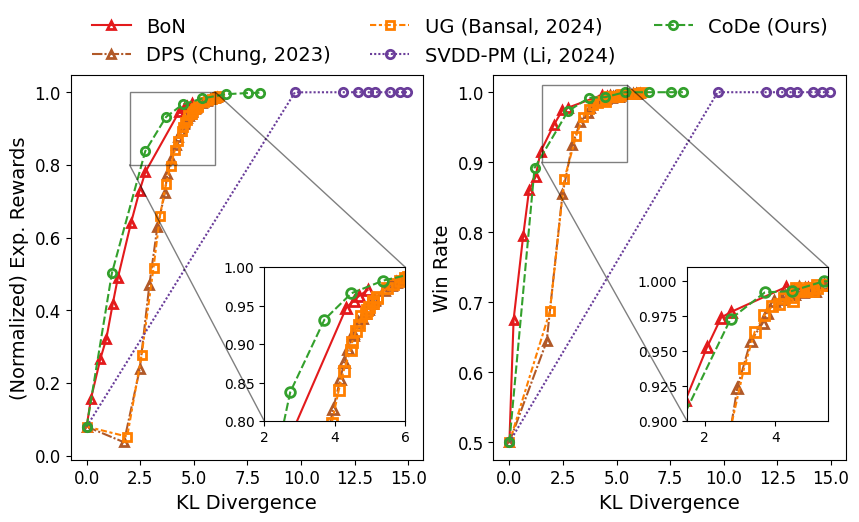

In [49]:
# for perf in ['rewards', 'win_rate']:
#     for div in ['fid', 'mmd', 'kl']:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

perf = ['rewards', 'win_rate']
div = ['kl', 'kl'] 

fig, axes = plt.subplots(1, 2, figsize=(10,5))

for i, ax in enumerate(axes.flatten()):

    g = sns.lineplot(plot_results, x=div[i], y=perf[i], hue='method', style='method',
                    linestyle='-', markers=markers, palette=palette, markersize=6, fillstyle='none', markeredgecolor=None, markeredgewidth=2,
                    style_order=list(palette.keys()), ax=ax, sort=False)

    ax.get_legend().remove()

    if i == 0:
      x1, x2, y1, y2 = 2, 6, 0.8, 1.0  # subregion of the original image
    else:
      x1, x2, y1, y2 = 1.5, 5.5, 0.9, 1.01  # subregion of the original image

    axins = ax.inset_axes(
        [0.55, 0.1, .4, .4],
        xlim=(x1, x2), ylim=(y1, y2)) #, xticklabels=[], yticklabels=[])
    ax.indicate_inset_zoom(axins, edgecolor="black")

    g = sns.lineplot(plot_results, x=div[i], y=perf[i], hue='method', style='method',
                    linestyle='-', markers=markers, palette=palette, markersize=7, fillstyle='none', markeredgecolor=None, markeredgewidth=2,
                    style_order=list(palette.keys()), ax=axins, sort=False, legend=False)
      
    axins.set_xlabel('')
    axins.set_ylabel('')

    ax.set_xlabel(labels[div[i]], fontsize=14)
    ax.set_ylabel(labels[perf[i]], fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

handles, l_labels = ax.get_legend_handles_labels()
fig.legend(handles, l_labels, bbox_to_anchor=(0.90, 1.03), ncols=3, fontsize=14, frameon=False)
# plt.show()
plt.savefig(export_path.joinpath(f'result_{setting}.png'), dpi=300, bbox_inches='tight')
# # plt.close()

In [31]:
export_path

PosixPath('outputs_toy_final/plots_ood')

In [ ]:
import plotly.express as px

div = 'win_rate' # 'rewards', 'win_rate'
perf = 'kl' # 'fid', 'mmd', 'kl'

g = px.line(plot_results, x=perf, y=div, color='method', symbol='method', markers=['o', '^'],
            labels={
                     "rewards": "Expected Rewards",
                     "kl": "KL Divergence",
                     "fid": "FD",
                     "mmd": "MMD",
                     "win_rate": "Win Rate",
                     "method": "Guidance Method"
                 }
            )
g.show()
# g.legend_.set_title(None)
# px.move_legend("upper center", bbox_to_anchor=(0.5, 1.25), ncol=4)

In [ ]:
import plotly.express as px

div = 'rewards' # 'rewards', 'win_rate'
perf = 'kl' # 'fid', 'mmd', 'kl'

g = px.line(plot_results, x=perf, y=div, color='method', symbol='method', markers=['o', '^'],
            labels={
                     "rewards": "Expected Rewards",
                     "kl": "KL Divergence",
                     "fid": "FD",
                     "mmd": "MMD",
                     "win_rate": "Win Rate",
                     "method": "Guidance Method"
                 }
            )
g.show()
# g.legend_.set_title(None)
# px.move_legend("upper center", bbox_to_anchor=(0.5, 1.25), ncol=4)

In [ ]:
IS_OOD = False

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

    setting = 'id'

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

    setting = 'ood'

# export_path = Path(OUTPUTS_DIR).joinpath(f'plots_{setting}')
# if not Path.exists(export_path):
#     Path.mkdir(export_path, exist_ok=True, parents=True)

mu_b_1 = torch.tensor([5.0, 3.0]).to('cuda')
Cov_b_1 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_2 = torch.tensor([3.0, 7.0]).to('cuda')
Cov_b_2 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_3 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_b_3 = torch.tensor([2.0, 2.0]).to('cuda')

gmm_b = GaussianMixture([mu_b_1, mu_b_2, mu_b_3],[Cov_b_1, Cov_b_2, Cov_b_3], [1.0, 1.0, 1.0])

p_samples = np.load(f'{OUTPUTS_DIR}/uncond/gensample.npy')

s = 10
prior = gmm_b.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()
rew_p = gmm.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()
posterior = prior * rew_p
posterior /= np.sum(posterior)

reward = np.sum(posterior * rew_p)

kl = np.sum(posterior * np.log(posterior/prior))

print(f'KL: {kl} Rewards: {reward}')

# mean_p_scaled = np.average(p_samples, weights=posterior, axis=0)
# cov_p_scaled = np.cov(p_samples.T, aweights=posterior)

# mu_aligned = torch.tensor(mean_p_scaled).to('cuda')
# Cov_aligned = torch.tensor([cov_p_scaled[0][0], cov_p_scaled[1][1]]).to('cuda')

# print(kl_mvn(mean_p_scaled, cov_p_scaled, p_mean, p_cov))

# gmm_aligned = GaussianMixture([mu_aligned],[Cov_aligned], [1.0])
# gmm_aligned_samples, _, _ = gmm_aligned.sample(1000)

sns.scatterplot(x=p_samples[:,0], y=p_samples[:,1], hue=posterior)
plt.show()
# sns.scatterplot(x=gmm_aligned_samples[:,0], y=gmm_aligned_samples[:,1])

# mean_p_scale2 = np.sum(posterior.reshape(1, 1000).T * p_samples, axis=0)
# print(mean_p_scale2)

# sns.scatterplot(x=p_samples[:,0], y=p_samples[:,1], hue=posterior)
# plt.plot(mean_p[0], mean_p[1], marker='x', markersize=10, c='r')
# plt.plot(mean_p_scaled[0], mean_p_scaled[1], marker='x', markersize=10, c='b')
# plt.plot(mean_p_scale2[0], mean_p_scale2[1], marker='x', markersize=10, c='g')
# plt.show()

# kls = []
# rewards = []
# for s in np.arange(1, 110, 10):

#     prior = gmm_b.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()
#     rew_p = gmm.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()
#     posterior = prior * np.exp(s * rew_p)
#     posterior /= np.sum(posterior)

#     kl = np.mean(np.log(posterior/prior))

#     reward = np.sum(posterior * rew_p)

#     kls.append(kl)
#     rewards.append(reward)

#     # print(f's = {s} KL = {kl} Expected Reward = {reward}')

# # sns.scatterplot(x=p_samples[:,0], y=p_samples[:,1], hue=posterior)
# sns.lineplot(x=kls, y=rewards)
# plt.show()

## Ablations

In [64]:
def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = np.log(gmm_p.pdf(X))
    log_q_X = np.log(gmm_q.pdf(X))
    return log_p_X.mean() - log_q_X.mean()

In [12]:
x = np.arange(15.5, -6, -0.1) # -5, 15
y = np.arange(-5, 16.5, 0.1)
X,Y = np.meshgrid(x, y) # grid of point

In [7]:
# def optimal_posterior(m1, m2, lamda):
    
#     mu1, Cov1 = m1[0], m2[1]
#     mu2, Cov2 = m2[0], m2[1]

#     Cov1 = torch.diag(Cov1)
#     Cov2 = torch.diag(Cov2)

#     Cov2 = (1/lamda) * Cov2

#     mu_p = ((Cov2 @ torch.linalg.inv(Cov1 + Cov2)) @ mu1) + ((Cov1 @ torch.linalg.inv(Cov1 + Cov2)) @ mu2)
#     Cov_p = (Cov1 @ torch.linalg.inv(Cov1 + Cov2)) @ Cov2

#     return [mu_p, Cov_p.diag()]

In [15]:
mu_b_1 = torch.tensor([5.0, 3.0]).to('cuda')
Cov_b_1 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_2 = torch.tensor([3.0, 7.0]).to('cuda')
Cov_b_2 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_3 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_b_3 = torch.tensor([2.0, 2.0]).to('cuda')

gmm_b = GaussianMixture([mu_b_1, mu_b_2, mu_b_3],[Cov_b_1, Cov_b_2, Cov_b_3], [1.0, 1.0, 1.0])

In [38]:
# @title Reward vs Divergence Plots

IS_OOD = True

if not IS_OOD:
    mu_r1 = torch.tensor([5.0, 3.0]).to('cuda')
    Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

    gmm = GaussianMixture([mu_r1],[Cov_r1], [1.0])

    setting = 'id'

else:
    mu_r2 = torch.tensor([9.0, 3.0]).to('cuda')
    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')

    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

    setting = 'ood'

export_path = Path(OUTPUTS_DIR).joinpath(f'plots_{setting}')
if not Path.exists(export_path):
    Path.mkdir(export_path, exist_ok=True, parents=True)

p_samples = np.load(f'{OUTPUTS_DIR}/uncond/gensample.npy')
p_mean = np.mean(p_samples, axis=0)
p_cov = np.cov(p_samples.T)

rew_p = gmm.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()

results = {
    'win_rate': [],
    'rewards': [],
    'fid': [],
    'mmd': [],
    'kl': [],
    'method': []
}

#####################
# SDEdit + Best-of-K
#####################

strengths = np.arange(0.1,1.0,0.1).tolist()
for strength in strengths:

    results['rewards'].append(rew_p.mean())
    results['method'].append(f'SDEdit + BoN [r: {round(strength, 2)}]')
    results['fid'].append(0.0)
    results['kl'].append(0.0)
    results['mmd'].append(0.0)
    results['win_rate'].append(0.5)

    n_vals = np.arange(2, 12, 2).tolist()
    n_vals.extend(np.arange(20, 50, 10).tolist())

    for i, n in enumerate(n_vals):

        pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_BoN_{setting}/strength_{round(strength * 10)}_n_{n}/gensample.npy')
        pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
        pi_mean = np.mean(pi_samples_filtered, axis=0)
        pi_cov = np.cov(pi_samples_filtered.T)

        # p_samples_bok = np.load(f'{OUTPUTS_DIR}/SDEdit_BoN_{setting}/strength_4_n_{n}/gen_uncond.npy')
        # p_mean_bok = np.mean(p_samples_bok, axis=0)
        # p_cov_bok = np.cov(p_samples_bok.T)

        rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

        results['rewards'].append(rew.mean())
        results['method'].append(f'SDEdit + BoN [r: {round(strength, 2)}]')
        results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
        results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
        results['mmd'].append(mmd_rbf(pi_samples, p_samples))
        results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))


# #######################
# # SDEdit + CD-FUDGE (block-wise)
# #######################

# strengths = np.arange(0.1,1.0,0.1).tolist()
# # block_sizes = [10, 20, 40, 80]

# block_sizes = [20]

# # for strength in strengths:
# for i, n in enumerate(n_vals):

#     for blocksize in block_sizes:

#         results['rewards'].append(rew_p.mean())
#         # results['method'].append(f'SDEdit + CoDe (Ours) [block: {blocksize}, r: {round(strength, 2)}]')
#         results['method'].append(f'SDEdit + CoDe (Ours) [block: {blocksize}, n: {n}]')
#         results['fid'].append(0.0)
#         results['kl'].append(0.0)
#         results['mmd'].append(0.0)
#         results['win_rate'].append(0.5)

#         n_vals = np.arange(2, 12, 2).tolist()
#         n_vals.extend(np.arange(20, 50, 10).tolist())

#         for strength in strengths:

#             pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_CD_b{blocksize}_{setting}/strength_{round(strength * 10)}_n_{n}/gensample.npy')
#             pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
#             pi_mean = np.mean(pi_samples_filtered, axis=0)
#             pi_cov = np.cov(pi_samples_filtered.T)

#             rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

#             results['rewards'].append(rew.mean())
#             # results['method'].append(f'SDEdit + CoDe (Ours) [block: {blocksize}, r: {round(strength, 2)}]')
#             results['method'].append(f'SDEdit + CoDe (Ours) [block: {blocksize}, n: {n}]')
#             results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
#             results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
#             results['mmd'].append(mmd_rbf(pi_samples, p_samples))
#             results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

# ################################
# # SDEdit + CD-FUDGE (token-wise)
# ################################

# results['rewards'].append(rew_p.mean())
# results['method'].append(f'SDEdit + SVDD-MC')
# results['fid'].append(0.0)
# results['kl'].append(0.0)
# results['mmd'].append(0.0)
# results['win_rate'].append(0.5)

# n_vals = np.arange(2, 12, 2).tolist()
# n_vals.extend(np.arange(20, 50, 10).tolist())

# for i, n in enumerate(n_vals):

#     pi_samples = np.load(f'{OUTPUTS_DIR}/SDEdit_CD_b1_{setting}/strength_4_n_{n}/gensample.npy')
#     pi_samples_filtered = pi_samples[~np.any(np.isnan(pi_samples),axis=1)]
#     pi_mean = np.mean(pi_samples_filtered, axis=0)
#     pi_cov = np.cov(pi_samples_filtered.T)

#     rew = gmm.pdf(torch.from_numpy(pi_samples_filtered).to('cuda')).cpu().numpy()

#     results['rewards'].append(rew.mean())
#     results['method'].append(f'SDEdit + SVDD-MC')
#     results['fid'].append(calculate_fid(pi_mean, pi_cov, p_mean, p_cov))
#     results['kl'].append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
#     results['mmd'].append(mmd_rbf(pi_samples, p_samples))
#     results['win_rate'].append((rew > rew_p[~np.any(np.isnan(pi_samples),axis=1)]).astype(int).sum() / len(rew))

In [ ]:
pd.DataFrame(results)['method'].unique()

In [40]:
x = np.arange(15.5, -6, -0.1) 
y = np.arange(-5, 16.5, 0.1)
X,Y = np.meshgrid(x, y) 

x_flat = X.reshape(-1)
y_flat = Y.reshape(-1)
xy = np.column_stack((y_flat, x_flat))

p_samples = gmm_b.sample(1000)[0]
p_mean = np.mean(p_samples, axis=0)
p_cov = np.cov(p_samples.T)

for scale in np.arange(12, 0, -0.1):

    posterior = gmm_b.pdf(xy) * gmm.scaled_pdf(xy, scale=scale)
    posterior /= np.sum(posterior)

    inds = np.random.choice(xy.shape[0], size=1000, p=posterior)
    pi_samples = np.array([xy[idx] for idx in inds])

    pi_mean = np.mean(pi_samples, axis=0)
    pi_cov = np.cov(pi_samples.T)

    kl = kl_mvn(pi_mean, pi_cov, p_mean, p_cov)
    rew = gmm.pdf(torch.from_numpy(pi_samples).to('cuda')).cpu().numpy()

    results['method'].append(f'Optimal Policy')
    results['fid'].append(0.0)
    results['kl'].append(kl)
    results['mmd'].append(0.0)
    results['win_rate'].append((rew > rew_p).astype(int).sum() / len(rew))
    results['rewards'].append(np.mean(rew))

results['rewards'].append(0.0)
results['method'].append(f'Optimal Policy')
results['fid'].append(0.0)
results['kl'].append(0.0)
results['mmd'].append(0.0)
results['win_rate'].append(0.5)

In [41]:
results_df = pd.DataFrame(results)

In [ ]:
results_df['method'].unique()

In [42]:
plot_results = results_df

# .loc[results_df['method'].isin([
#     'Best-of-N', 
#     'Optimal Policy',
#     # 'DPS (Chung, 2023)',
#     # 'Universal Guidance (Bansal, 2024)', 
#     # 'CoDe (Ours) [block: 10]',
#     # 'CoDe (Ours) [block: 20]', 
#     # 'CoDe (Ours) [block: 40]',
#     # 'CoDe (Ours) [block: 80]',
#     # 'CoDe Updated (Ours) [block: 10]',
#     # 'CoDe Updated (Ours) [block: 20]',
#     # 'CoDe Updated (Ours) [block: 40]',
#     # 'CoDe (Ours) [block: 80]', 
#     # 'CoDe Updated (Ours) [block: 1000]',
#     # 'SVDD-MC (Li, 2024)',
#     # 'SDEdit (Meng, 2021)',
#     # 'SDEdit + BoN',
#     # 'SDEdit + DPS',
#     # 'SDEdit + Universal Guidance',
#     # 'SDEdit + SVDD-MC',
#     'SDEdit + CoDe (Ours) [block: 10]',
#     'SDEdit + CoDe (Ours) [block: 20]',
#     'SDEdit + CoDe (Ours) [block: 40]',
#     'SDEdit + CoDe (Ours) [block: 80]',
# ])]

# method_labels = {
#     'Best-of-N': 'BoN',
#     'SDEdit \+ BoN': 'C-BoN', 
#     r'CoDe.*': 'CoDe (Ours)',
#     r'SDEdit \+ CoDe.*': 'C-CoDe (Ours)',
# }

# plot_results['method'] = plot_results['method'].replace(regex=method_labels)

plot_results['rewards'] = plot_results['rewards']/np.max(plot_results['rewards'])

In [ ]:
import plotly.express as px

div = 'rewards' # 'rewards', 'win_rate'
perf = 'kl' # 'fid', 'mmd', 'kl'

g = px.line(plot_results, x=perf, y=div, color='method', symbol='method', markers=['o', '^'],
            labels={
                     "rewards": "Expected Rewards",
                     "kl": "KL Divergence",
                     "fid": "FD",
                     "mmd": "MMD",
                     "win_rate": "Win Rate",
                     "method": "Guidance Method"
                 }
            )
g.show()
# g.legend_.set_title(None)
# px.move_legend("upper center", bbox_to_anchor=(0.5, 1.25), ncol=4)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

g = sns.lineplot(plot_results, x='kl', y='rewards', hue='method', style='method',
            linestyle='-',
            ax=ax, markers=['o', '^'], sort=False)

g.legend_.set_title(None)
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.xlabel(r'$KL(\pi||p)$')
plt.ylabel('Normalized Expected Rewards')

plt.tight_layout()
plt.savefig(export_path.joinpath(f'opt_pol_rew.png'), dpi=300)
# plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

g = sns.lineplot(plot_results, x='kl', y='win_rate', hue='method', style='method',
            linestyle='-',
            ax=ax, markers=['o', '^'], sort=False)

g.legend_.set_title(None)
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.xlabel(r'$KL(\pi||p)$')
plt.ylabel('Win Rate')

plt.tight_layout()
plt.savefig(export_path.joinpath(f'opt_pol_wr.png'), dpi=300)
# plt.close()

# Ablating dist. btw Reward & Prior

In [12]:
mu_b_1 = torch.tensor([5.0, 3.0]).to('cuda')
Cov_b_1 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_2 = torch.tensor([3.0, 7.0]).to('cuda')
Cov_b_2 = torch.tensor([2.0, 2.0]).to('cuda')

mu_b_3 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_b_3 = torch.tensor([2.0, 2.0]).to('cuda')

gmm_b = GaussianMixture([mu_b_1, mu_b_2, mu_b_3],[Cov_b_1, Cov_b_2, Cov_b_3], [1.0, 1.0, 1.0])

results = dict()
result_vars = dict()

results['kls'] = []
result_vars['kls'] = []

Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')
for i, x in enumerate(np.arange(5.0, 16.0, 1.0)):
    mu_r2 = torch.tensor([x, 3.0]).to('cuda')

    gmm_r = GaussianMixture([mu_r2],[Cov_r2], [1.0])

    results['kls'].append(gmm_kl(gmm_r, gmm_b))
    result_vars['kls'].append(gmm_kl(gmm_r, gmm_b))

    
    print(f'{i} KL: {results["kls"][-1]}')

0 KL: 0.5830749098261299
1 KL: 0.682627989314871
2 KL: 0.974695080666109
3 KL: 1.468268831896606
4 KL: 2.1838638109595996
5 KL: 3.0671446516565677
6 KL: 4.186936690091354
7 KL: 5.5123767337239205
8 KL: 7.04809623766574
9 KL: 8.832425017020283
10 KL: 10.797851265222274


In [13]:
# model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
# model = model.to(DEVICE)
# model.eval()

# strengths = np.arange(0.2,0.5,0.1).tolist()

# for strength in strengths:

#     results[f'SDEdit (r={round(strength, 1)})'] = []

#     Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')
#     for i, x in tqdm(enumerate(np.arange(5.0, 16.0, 1.0)), total=11):
#         mu_r2 = torch.tensor([x, 3.0]).to('cuda')

#         gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

#         # n_vals = np.arange(1, 11, 1).tolist()
#         # n_vals.extend(np.arange(20, 210, 10).tolist())
#         n_vals = [50]

#         target_samples, _, _ = gmm.sample(NUM_SAMPLES)
#         target_samples = torch.from_numpy(target_samples).to(NOISE_SAMPLES.dtype)

#         curr_sample = copy.deepcopy(target_samples)

#         curr_sample = forward_diffusion_sample(curr_sample, int(strength*noise_scheduler.num_timesteps))
#         curr_sample = curr_sample.to(DEVICE)

#         noised_target = copy.deepcopy(curr_sample)

#         timesteps = list(range(len(noise_scheduler)))[::-1]
#         for i, t in enumerate(timesteps):

#             if t > strength*noise_scheduler.num_timesteps:
#                 continue

#             t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long().to(DEVICE) ###### Debug
#             with torch.no_grad():
#                 residual = model(curr_sample, t)

#             _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

#         rew = gmm.pdf(curr_sample).cpu().numpy()

#         print(f'{round(strength, 1)} {rew.mean()}')
#         results[f'SDEdit (r={round(strength, 1)})'].append(rew.mean())

#     #     fig, ax = plt.subplots()
#     #     ax.scatter(target_samples[:,0], target_samples[:,1], label='target')
#     #     ax.scatter(curr_sample[:,0].cpu().numpy(), curr_sample[:,1].cpu().numpy(), label='generated')
#     #     ax.scatter(noised_target[:,0].cpu().numpy(), noised_target[:,1].cpu().numpy(), label='noisy target')

#     #     plt.axis([-4,16,-4,13])
#     #     plt.legend()
#     #     plt.show()

#     # break

In [15]:

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

results['bon'] = []
result_vars[f'bon'] = []

Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')
for i, x in tqdm(enumerate(np.arange(5.0, 16.0, 1.0)), total=11):
    
    mu_r2 = torch.tensor([x, 3.0]).to('cuda')
    gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

    # n_vals = np.arange(1, 11, 1).tolist()
    # n_vals.extend(np.arange(20, 210, 10).tolist())
    n_vals = [100]

    found = False
    for n_val in n_vals:

        curr_sample = copy.deepcopy(NOISE_SAMPLES)
        curr_sample = curr_sample.repeat(n_val, 1)

        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(timesteps):
            t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE)
            with torch.no_grad():
                residual = model(curr_sample, t)

            _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

        reward = gmm.pdf(curr_sample)
        reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)
        all_samples = copy.deepcopy(curr_sample)

        # Find the direction that minimizes the loss
        select_ind = torch.max(reward, dim=0)[1]
        curr_sample = torch.cat([x.unsqueeze(0) for x in curr_sample.chunk(n_val)], dim=0)
        curr_sample = curr_sample.permute(1,0,2)
        result = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(curr_sample)], dim=0)) # TODO: Make it efficient

        rew = gmm.pdf(result).cpu().numpy()

        # if rew.mean() >= 0.020:
        #     print(f'{n_val} {rew.mean()}')
        #     results['bon'].append(n_val)
        #     found = True
        #     result_vars[f'bon'].append(torch.norm(torch.var(curr_sample, dim=0)))
        #     break

        print(f'{n_val} {rew.mean()}')
        results['bon'].append(rew.mean())
        result_vars[f'bon'].append(torch.norm(torch.var(curr_sample, dim=0)))

    # if not found:
    #     break

    #     fig, ax = plt.subplots()
    #     ax.scatter(all_samples[:,0].cpu().numpy(), all_samples[:,1].cpu().numpy(), label='all')
    #     ax.scatter(result[:,0].cpu().numpy(), result[:,1].cpu().numpy(), label='generated')

    #     plt.axis([-4,16,-4,13])
    #     plt.legend()
    #     plt.show()

    # break

  0%|                                                                                                                                                                                                                | 0/11 [00:00<?, ?it/s]

  9%|██████████████████▏                                                                                                                                                                                     | 1/11 [00:03<00:34,  3.44s/it]

100 0.03866384757058363


 18%|████████████████████████████████████▎                                                                                                                                                                   | 2/11 [00:06<00:30,  3.43s/it]

100 0.038763946508348045


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                 | 3/11 [00:10<00:27,  3.42s/it]

100 0.03847946505073854


 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 4/11 [00:13<00:23,  3.42s/it]

100 0.037718629068697225


 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 5/11 [00:17<00:20,  3.42s/it]

100 0.03601836201740482


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 6/11 [00:20<00:17,  3.42s/it]

100 0.03263288877778784


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 7/11 [00:23<00:13,  3.42s/it]

100 0.02637893795179846


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 8/11 [00:27<00:10,  3.42s/it]

100 0.018682437901249634


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 9/11 [00:30<00:06,  3.42s/it]

100 0.011296437485903806


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 10/11 [00:34<00:03,  3.42s/it]

100 0.0057123531812404964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.42s/it]

100 0.0024163477928705827


In [16]:
result_vars

{'kls': [0.5803745749549778,
  0.6807611274337777,
  0.9748354942655322,
  1.4675383222329135,
  2.1726092588352923,
  3.0751013298461904,
  4.18077276442988,
  5.508431477490391,
  7.046512220929468,
  8.814228588064225,
  10.800346845352692],
 'bon': [tensor(101.7633, device='cuda:0'),
  tensor(102.5453, device='cuda:0'),
  tensor(102.2082, device='cuda:0'),
  tensor(102.4226, device='cuda:0'),
  tensor(102.0199, device='cuda:0'),
  tensor(103.0059, device='cuda:0'),
  tensor(102.1803, device='cuda:0'),
  tensor(102.0139, device='cuda:0'),
  tensor(102.5009, device='cuda:0'),
  tensor(102.2768, device='cuda:0'),
  tensor(102.1160, device='cuda:0')]}

In [ ]:
model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

strengths = np.arange(0.1,0.5,0.1).tolist()

for strength in strengths:

    results[f'C-BoN (r={round(strength, 1)})'] = []
    result_vars[f'C-BoN (r={round(strength, 1)})'] = []

    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')
    for i, x in tqdm(enumerate(np.arange(5.0, 16.0, 1.0)), total=11):

        mu_r2 = torch.tensor([x, 3.0]).to('cuda')

        gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])
        # target_samples, _, _ = gmm.sample(NUM_SAMPLES)
        # target_samples = torch.from_numpy(target_samples).to(NOISE_SAMPLES.dtype)

        target_samples = mu_r2.repeat(NUM_SAMPLES, 1).to(NOISE_SAMPLES.dtype)

        found = False
        # n_vals = np.arange(1, 11, 1).tolist()
        # n_vals.extend(np.arange(20, 210, 10).tolist())
        n_vals = [100]

        for n_val in n_vals:

            curr_sample = copy.deepcopy(target_samples)

            curr_sample = forward_diffusion_sample(curr_sample, int(strength*noise_scheduler.num_timesteps))
            curr_sample = curr_sample.to(DEVICE)

            noised_target = copy.deepcopy(curr_sample)

            curr_sample = curr_sample.repeat(n_val, 1)

            timesteps = list(range(len(noise_scheduler)))[::-1]
            for i, t in enumerate(timesteps):

                if t > strength*noise_scheduler.num_timesteps:
                    continue

                t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE) ###### Debug
                with torch.no_grad():
                    residual = model(curr_sample, t)

                _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

            all_samples = copy.deepcopy(curr_sample)

            reward = gmm.pdf(curr_sample)

            all_rewards = copy.deepcopy(reward)
            reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)

            # Find the direction that minimizes the loss
            select_ind = torch.max(reward, dim=0)[1]
            curr_sample = torch.cat([x.unsqueeze(0) for x in curr_sample.chunk(n_val)], dim=0)
            curr_sample = curr_sample.permute(1,0,2)
            result = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(curr_sample)], dim=0)) # TODO: Make it efficient
            # result = result.detach().cpu()

            rew = gmm.pdf(result).cpu().numpy()
            # print(f'{n_val} {rew.mean()}')

            if rew.mean() >= 0.020:
                print(f'{strength} {n_val} {rew.mean()}')
                results[f'C-BoN (r={round(strength, 1)})'].append(n_val)
                found = True
                result_vars[f'C-BoN (r={round(strength, 1)})'].append(torch.norm(torch.var(curr_sample, dim=1)))
                break

            # print(f'{strength} {n_val} {rew.mean()}')
            # results[f'C-BoN (r={round(strength, 1)})'].append(rew.mean())

            # fig, ax = plt.subplots()
            # # ax.scatter(target_samples[:,0], target_samples[:,1], label='target')
            # # ax.scatter(all_samples[:,0].cpu().numpy(), all_samples[:,1].cpu().numpy(), label='all')
            # # ax.scatter(noised_target[:,0].cpu().numpy(), noised_target[:,1].cpu().numpy(), label='noisy target')
            # # ax.scatter(result[:,0].cpu().numpy(), result[:,1].cpu().numpy(), label='generated')

            # sns.scatterplot(x=all_samples[:,0].cpu().numpy(), y=all_samples[:,1].cpu().numpy(), hue=all_rewards.cpu().numpy())
            # sns.scatterplot(x=noised_target[:,0].cpu().numpy(), y=noised_target[:,1].cpu().numpy())

            # plt.axis([-4,16,-4,13])
            # plt.legend()
            # plt.show()

        # if not found:
        #     break

In [ ]:
model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

bsizes = [160, 320]
# bsizes = [40, 80]

for bsize in bsizes:

    results[f'CoDe (block={bsize})'] = []
    result_vars[f'CoDe (block={bsize})'] = []

    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')
    for i, x in tqdm(enumerate(np.arange(5.0, 16.0, 1.0)), total=11):

        mu_r2 = torch.tensor([x, 3.0]).to('cuda')

        gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

        found = False
        # n_vals = np.arange(1, 11, 1).tolist()
        # n_vals.extend(np.arange(20, 210, 10).tolist())
        n_vals = [50]
        for n_val in n_vals:

            curr_sample = copy.deepcopy(NOISE_SAMPLES)
            curr_sample = curr_sample.repeat(n_val, 1)

            timesteps = list(range(len(noise_scheduler)))[::-1]
            for i, t in enumerate(timesteps):
                t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE)

                with torch.no_grad():
                    residual = model(curr_sample, t)

                _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

                if ((i + 1) % bsize == 0) or (t[0] == timesteps[-1]): # at the end of block do BoN
                    
                    if t[0] > timesteps[-1]: # If not final step use estimates x0
                        
                        prev_t = torch.from_numpy(np.repeat(timesteps[i + 1], n_val * NUM_SAMPLES)).long().to(DEVICE)
                        with torch.no_grad():
                            residual = model(curr_sample, prev_t)

                        pred_x0 = noise_scheduler.reconstruct_x0(curr_sample, timesteps[i + 1], residual)
                        reward = gmm.pdf(pred_x0)
                    else:
                        reward = gmm.pdf(curr_sample)

                    reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)
                    select_ind = torch.max(reward, dim=0)[1]

                    gen_sample = copy.deepcopy(curr_sample)
                    gen_sample = torch.cat([x.unsqueeze(0) for x in gen_sample.chunk(n_val)], dim=0)
                    gen_sample = gen_sample.permute(1,0,2)
                    curr_sample = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(gen_sample)], dim=0)) # TODO: Make it efficient
                
                    if t[0] > timesteps[-1]: # If not the end replicate n times
                        curr_sample = curr_sample.repeat(n_val, 1)

            rew = gmm.pdf(curr_sample).cpu().numpy()

            # fig, ax = plt.subplots()
            # # ax.scatter(target_samples[:,0], target_samples[:,1], label='target')
            # # ax.scatter(all_samples[:,0].cpu().numpy(), all_samples[:,1].cpu().numpy(), label='all')
            # # ax.scatter(noised_target[:,0].cpu().numpy(), noised_target[:,1].cpu().numpy(), label='noisy target')
            # # ax.scatter(result[:,0].cpu().numpy(), result[:,1].cpu().numpy(), label='generated')

            # sns.scatterplot(x=curr_sample[:,0].cpu().numpy(), y=curr_sample[:,1].cpu().numpy(), hue=rew)

            # plt.axis([-4,16,-4,13])
            # plt.legend()
            # plt.show()

            if rew.mean() >= 0.020:
                print(f'{x} {bsize} {n_val} {rew.mean()}')
                results[f'CoDe (block={bsize})'].append(n_val)
                found = True
                result_vars[f'CoDe (block={bsize})'].append(torch.norm(torch.var(curr_sample, dim=1)))
                break
            else:
                print(f'Else: {x} {bsize} {n_val} {rew.mean()}')

            # print(f'{x} {bsize} {n_val} {rew.mean()}')
            # results[f'CoDe (block={bsize})'].append(rew.mean())

        # if not found:
        #     break

    # break       

  9%|███████████▊                                                                                                                      | 1/11 [00:02<00:21,  2.18s/it]

5.0 160 50 0.03978174469993137


 18%|███████████████████████▋                                                                                                          | 2/11 [00:04<00:19,  2.17s/it]

6.0 160 50 0.03978127334555374


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:06<00:17,  2.17s/it]

7.0 160 50 0.03978149527113505


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:08<00:15,  2.17s/it]

8.0 160 50 0.03978145238791861


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:10<00:13,  2.17s/it]

9.0 160 50 0.03978101982483404


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:13<00:10,  2.17s/it]

10.0 160 50 0.03978107194699092


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:15<00:08,  2.17s/it]

11.0 160 50 0.03975163892645914


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/11 [00:17<00:06,  2.17s/it]

12.0 160 50 0.0393565332832483


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:19<00:04,  2.17s/it]

13.0 160 50 0.03698290534848416


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:21<00:02,  2.17s/it]

14.0 160 50 0.030571343236626275


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.17s/it]


15.0 160 50 0.02137120803667868


  9%|███████████▊                                                                                                                      | 1/11 [00:02<00:21,  2.11s/it]

5.0 320 50 0.03972996626338903


 18%|███████████████████████▋                                                                                                          | 2/11 [00:04<00:19,  2.11s/it]

6.0 320 50 0.039720944160749005


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:06<00:16,  2.11s/it]

7.0 320 50 0.039727434004302196


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:08<00:14,  2.11s/it]

8.0 320 50 0.03971119112166061


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:10<00:12,  2.12s/it]

9.0 320 50 0.03956056889692255


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:12<00:10,  2.12s/it]

10.0 320 50 0.03893085249358512


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:14<00:08,  2.11s/it]

11.0 320 50 0.03648579119485157


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/11 [00:16<00:06,  2.11s/it]

12.0 320 50 0.031086136727041264


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:19<00:04,  2.12s/it]

13.0 320 50 0.023056609948114197


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:21<00:02,  2.12s/it]

14.0 320 50 0.014395517902796872


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.11s/it]

15.0 320 50 0.0072706771834545785


In [ ]:
model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

bsizes = [1]
# bsizes = [40, 80]

for bsize in bsizes:

    results[f'SVDD-PM (block={bsize})'] = []
    result_vars[f'SVDD-PM (block={bsize})'] = []

    Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')
    for i, x in tqdm(enumerate(np.arange(5.0, 16.0, 1.0)), total=11):

        mu_r2 = torch.tensor([x, 3.0]).to('cuda')

        gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

        found = False
        # n_vals = np.arange(1, 11, 1).tolist()
        # n_vals.extend(np.arange(20, 210, 10).tolist())
        n_vals = [50]
        for n_val in n_vals:

            curr_sample = copy.deepcopy(NOISE_SAMPLES)
            curr_sample = curr_sample.repeat(n_val, 1)

            timesteps = list(range(len(noise_scheduler)))[::-1]
            for i, t in enumerate(timesteps):
                t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE)

                with torch.no_grad():
                    residual = model(curr_sample, t)

                _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

                if ((i + 1) % bsize == 0) or (t[0] == timesteps[-1]): # at the end of block do BoN
                    
                    if t[0] > timesteps[-1]: # If not final step use estimates x0
                        
                        prev_t = torch.from_numpy(np.repeat(timesteps[i + 1], n_val * NUM_SAMPLES)).long().to(DEVICE)
                        with torch.no_grad():
                            residual = model(curr_sample, prev_t)

                        pred_x0 = noise_scheduler.reconstruct_x0(curr_sample, timesteps[i + 1], residual)
                        reward = gmm.pdf(pred_x0)
                    else:
                        reward = gmm.pdf(curr_sample)

                    reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)
                    select_ind = torch.max(reward, dim=0)[1]

                    gen_sample = copy.deepcopy(curr_sample)
                    gen_sample = torch.cat([x.unsqueeze(0) for x in gen_sample.chunk(n_val)], dim=0)
                    gen_sample = gen_sample.permute(1,0,2)
                    curr_sample = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(gen_sample)], dim=0)) # TODO: Make it efficient
                
                    if t[0] > timesteps[-1]: # If not the end replicate n times
                        curr_sample = curr_sample.repeat(n_val, 1)

            rew = gmm.pdf(curr_sample).cpu().numpy()

            # fig, ax = plt.subplots()
            # # ax.scatter(target_samples[:,0], target_samples[:,1], label='target')
            # # ax.scatter(all_samples[:,0].cpu().numpy(), all_samples[:,1].cpu().numpy(), label='all')
            # # ax.scatter(noised_target[:,0].cpu().numpy(), noised_target[:,1].cpu().numpy(), label='noisy target')
            # # ax.scatter(result[:,0].cpu().numpy(), result[:,1].cpu().numpy(), label='generated')

            # sns.scatterplot(x=curr_sample[:,0].cpu().numpy(), y=curr_sample[:,1].cpu().numpy(), hue=rew)

            # plt.axis([-4,16,-4,13])
            # plt.legend()
            # plt.show()

            # if rew.mean() >= 0.020:
            #     print(f'{x} {bsize} {n_val} {rew.mean()}')
            #     results[f'SVDD-PM (block={bsize})'].append(n_val)
            #     found = True
            #     result_vars[f'SVDD-PM (block={bsize})'].append(torch.norm(torch.var(curr_sample, dim=1)))
            #     break
            # else:
            #     print(f'Else: {x} {bsize} {n_val} {rew.mean()}')

            print(f'{x} {bsize} {n_val} {rew.mean()}')
            results[f'SVDD-PM (block={bsize})'].append(rew.mean())
            result_vars[f'SVDD-PM (block={bsize})'].append(torch.norm(torch.var(curr_sample, dim=0)))

        # if not found:
        #     break

    # break

  9%|██████████████████▏                                                                                                                                                                                     | 1/11 [00:19<03:16, 19.63s/it]

5.0 1 50 0.03978871971525648


 18%|████████████████████████████████████▎                                                                                                                                                                   | 2/11 [00:39<02:57, 19.67s/it]

6.0 1 50 0.03978871812646367


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                 | 3/11 [00:58<02:37, 19.63s/it]

7.0 1 50 0.03978871544205209


 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 4/11 [01:18<02:17, 19.65s/it]

8.0 1 50 0.03978871317785924


 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 5/11 [01:38<01:57, 19.65s/it]

9.0 1 50 0.03978871104269673


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 6/11 [01:57<01:38, 19.63s/it]

10.0 1 50 0.039788708599429595


In [ ]:
model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

bsizes = [160, 320]
# bsizes = [40, 80]

for bsize in bsizes:

    strengths = np.arange(0.1,0.5,0.1).tolist()

    for strength in strengths:

        results[f'C-CoDe (r={round(strength, 1)}, block={bsize})'] = []
        result_vars[f'C-CoDe (r={round(strength, 1)}, block={bsize})'] = []

        Cov_r2 = torch.tensor([2.0, 2.0]).to('cuda')
        for i, x in tqdm(enumerate(np.arange(5.0, 16.0, 1.0)), total=11):
            
            mu_r2 = torch.tensor([x, 3.0]).to('cuda')

            gmm = GaussianMixture([mu_r2],[Cov_r2], [1.0])

            # target_samples, _, _ = gmm.sample(NUM_SAMPLES)
            # target_samples = torch.from_numpy(target_samples).to(NOISE_SAMPLES.dtype)

            target_samples = mu_r2.repeat(NUM_SAMPLES, 1).to(NOISE_SAMPLES.dtype)

            found = False
            # n_vals = np.arange(1, 11, 1).tolist()
            # n_vals.extend(np.arange(20, 210, 10).tolist())
            n_vals = [50]

            for n_val in n_vals:

                curr_sample = copy.deepcopy(target_samples).to(NOISE_SAMPLES.dtype)
                curr_sample = forward_diffusion_sample(curr_sample, int(strength*noise_scheduler.num_timesteps))
                curr_sample = curr_sample.to(DEVICE)

                noised_target = copy.deepcopy(curr_sample)

                curr_sample = curr_sample.repeat(n_val, 1)

                step_counter = 0

                timesteps = list(range(len(noise_scheduler)))[::-1]
                for i, t in enumerate(timesteps):
                    if t > strength*noise_scheduler.num_timesteps:
                        continue

                    step_counter += 1
            
                    t = torch.from_numpy(np.repeat(t, n_val * NUM_SAMPLES)).long().to(DEVICE) ###### Debug

                    with torch.no_grad():
                        residual = model(curr_sample, t)

                    _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

                    if ((step_counter + 1) % bsize == 0) or (t[0] == timesteps[-1]): # at the end of block do BoN
                        
                        if t[0] > timesteps[-1]: # If not final step use estimates x0
                            
                            prev_t = torch.from_numpy(np.repeat(timesteps[i + 1], n_val * NUM_SAMPLES)).long().to(DEVICE)
                            with torch.no_grad():
                                residual = model(curr_sample, prev_t)

                            pred_x0 = noise_scheduler.reconstruct_x0(curr_sample, timesteps[i + 1], residual)
                            reward = gmm.pdf(pred_x0)
                        else:
                            reward = gmm.pdf(curr_sample)

                        # fig, ax = plt.subplots()
                        # sns.scatterplot(x=curr_sample[:,0].cpu().numpy(), y=curr_sample[:,1].cpu().numpy(), hue=reward.cpu().numpy())
                        # plt.axis([-4,16,-4,13])
                        # plt.show()

                        reward = torch.cat([x.unsqueeze(0) for x in reward.chunk(n_val)], dim=0)
                        select_ind = torch.max(reward, dim=0)[1]

                        gen_sample = copy.deepcopy(curr_sample)
                        gen_sample = torch.cat([x.unsqueeze(0) for x in gen_sample.chunk(n_val)], dim=0)
                        gen_sample = gen_sample.permute(1,0,2)
                        curr_sample = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(gen_sample)], dim=0)) # TODO: Make it efficient
                    
                        if t[0] > timesteps[-1]: # If not the end replicate n times
                            curr_sample = curr_sample.repeat(n_val, 1)

                rew = gmm.pdf(curr_sample).cpu().numpy()

                if rew.mean() >= 0.020:
                    print(f'{x} {bsize} {n_val} {rew.mean()}')
                    results[f'C-CoDe (r={round(strength, 1)}, block={bsize})'].append(n_val)
                    found = True
                    result_vars[f'C-CoDe (r={round(strength, 1)}, block={bsize})'].append(torch.norm(torch.var(curr_sample, dim=1)))
                    break
                else:
                    print(f'Else: {x} {bsize} {n_val} {rew.mean()}')
                
                

                # print(f'{x} {bsize} {n_val} {rew.mean()}')
                # results[f'C-CoDe (r={round(strength, 1)}, block={bsize})'].append(rew.mean())

                # fig, ax = plt.subplots()
                # # ax.scatter(target_samples[:,0], target_samples[:,1], label='target')
                # # ax.scatter(all_samples[:,0].cpu().numpy(), all_samples[:,1].cpu().numpy(), label='all')
                # sns.scatterplot(x=noised_target[:,0].cpu().numpy(), y=noised_target[:,1].cpu().numpy())
                # # ax.scatter(result[:,0].cpu().numpy(), result[:,1].cpu().numpy(), label='generated')

                # sns.scatterplot(x=curr_sample[:,0].cpu().numpy(), y=curr_sample[:,1].cpu().numpy(), hue=rew)

                # plt.axis([-4,16,-4,13])
                # plt.legend()
                # plt.show()

            # if not found:
            #     break

  9%|███████████▊                                                                                                                      | 1/11 [00:00<00:02,  4.08it/s]

5.0 160 50 0.03968433700766383
6.0 160 50 0.03969196061395105


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:00<00:01,  4.26it/s]

7.0 160 50 0.03969772909227375


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:00<00:01,  4.29it/s]

8.0 160 50 0.03969718960002328


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:01<00:01,  4.30it/s]

9.0 160 50 0.039671624405818263


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:01<00:01,  4.29it/s]

10.0 160 50 0.03967961562081699


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:01<00:00,  4.30it/s]

11.0 160 50 0.039670914801851864
12.0 160 50 0.039625928749277076


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:02<00:00,  4.32it/s]

13.0 160 50 0.039488639971104744


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:02<00:00,  4.32it/s]

14.0 160 50 0.039129974806529036


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.29it/s]


15.0 160 50 0.03841562606710784


  9%|███████████▊                                                                                                                      | 1/11 [00:00<00:04,  2.18it/s]

5.0 160 50 0.039719294362678584


 18%|███████████████████████▋                                                                                                          | 2/11 [00:00<00:04,  2.17it/s]

6.0 160 50 0.039692733718015565


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:01<00:03,  2.17it/s]

7.0 160 50 0.039704278212222936


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:01<00:03,  2.17it/s]

8.0 160 50 0.03970663860396341


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:02<00:02,  2.17it/s]

9.0 160 50 0.03968718276136533


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:02<00:02,  2.17it/s]

10.0 160 50 0.03963908884588711


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:03<00:01,  2.17it/s]

11.0 160 50 0.039596388228916604


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/11 [00:03<00:01,  2.17it/s]

12.0 160 50 0.03942729359806368


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:04<00:00,  2.17it/s]

13.0 160 50 0.03909533191791567


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:04<00:00,  2.17it/s]

14.0 160 50 0.03824039021310598


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


15.0 160 50 0.03619005637250942


  9%|███████████▊                                                                                                                      | 1/11 [00:00<00:06,  1.49it/s]

5.0 160 50 0.03965427698176806


 18%|███████████████████████▋                                                                                                          | 2/11 [00:01<00:06,  1.49it/s]

6.0 160 50 0.03966850321735663


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:02<00:05,  1.49it/s]

7.0 160 50 0.0396722558358246


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:02<00:04,  1.49it/s]

8.0 160 50 0.03965962854460032


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:03<00:04,  1.49it/s]

9.0 160 50 0.039583347039789274


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:04<00:03,  1.49it/s]

10.0 160 50 0.039548400718157704


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:04<00:02,  1.49it/s]

11.0 160 50 0.03940008439981735


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/11 [00:05<00:02,  1.49it/s]

12.0 160 50 0.03907944867250845


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:06<00:01,  1.49it/s]

13.0 160 50 0.038207530485711245


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:06<00:00,  1.49it/s]

14.0 160 50 0.036350921825376005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.49it/s]


15.0 160 50 0.032687715113413236


  9%|███████████▊                                                                                                                      | 1/11 [00:00<00:08,  1.11it/s]

5.0 160 50 0.03975602343493096


 18%|███████████████████████▋                                                                                                          | 2/11 [00:01<00:08,  1.11it/s]

6.0 160 50 0.03976029010942747


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:02<00:07,  1.11it/s]

7.0 160 50 0.039765882854604195


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:03<00:06,  1.11it/s]

8.0 160 50 0.03975185000619323


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:04<00:05,  1.11it/s]

9.0 160 50 0.03969480644677061


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:05<00:04,  1.11it/s]

10.0 160 50 0.03962385313568313


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:06<00:03,  1.11it/s]

11.0 160 50 0.039437636708437085


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/11 [00:07<00:02,  1.11it/s]

12.0 160 50 0.03891396547460496


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:08<00:01,  1.11it/s]

13.0 160 50 0.03775760621068585


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:09<00:00,  1.11it/s]

14.0 160 50 0.03486183208718749


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.11it/s]


15.0 160 50 0.029471462265782233


  9%|███████████▊                                                                                                                      | 1/11 [00:00<00:02,  4.34it/s]

5.0 320 50 0.03969654731002581


 18%|███████████████████████▋                                                                                                          | 2/11 [00:00<00:02,  4.30it/s]

6.0 320 50 0.039682359575299087


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:00<00:01,  4.31it/s]

7.0 320 50 0.03969395669609669
8.0 320 50 0.03969594171282366


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:01<00:01,  4.33it/s]

9.0 320 50 0.03967417371141384
10.0 320 50 0.03967808083834965


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:01<00:00,  4.33it/s]

11.0 320 50 0.03965078482879834
12.0 320 50 0.03962531185376202


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:02<00:00,  4.33it/s]

13.0 320 50 0.03949091609530136


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:02<00:00,  4.33it/s]

14.0 320 50 0.039165224067912965
15.0 320 50 0.03838041867103119


  9%|███████████▊                                                                                                                      | 1/11 [00:00<00:04,  2.27it/s]

5.0 320 50 0.03941475669218765


 18%|███████████████████████▋                                                                                                          | 2/11 [00:00<00:03,  2.26it/s]

6.0 320 50 0.03941184339154736


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:01<00:03,  2.26it/s]

7.0 320 50 0.039399529768805716


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:01<00:03,  2.26it/s]

8.0 320 50 0.03939480790930154


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:02<00:02,  2.26it/s]

9.0 320 50 0.039337076014002444


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:02<00:02,  2.26it/s]

10.0 320 50 0.03931357065481838


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:03<00:01,  2.26it/s]

11.0 320 50 0.03919868703259877


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/11 [00:03<00:01,  2.26it/s]

12.0 320 50 0.03889421400998089


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:03<00:00,  2.26it/s]

13.0 320 50 0.03838269472555681


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:04<00:00,  2.26it/s]

14.0 320 50 0.03703658504282339


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


15.0 320 50 0.03431165216468211


  9%|███████████▊                                                                                                                      | 1/11 [00:00<00:06,  1.53it/s]

5.0 320 50 0.03882519774853725


 18%|███████████████████████▋                                                                                                          | 2/11 [00:01<00:05,  1.53it/s]

6.0 320 50 0.03893816084071814


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:01<00:05,  1.53it/s]

7.0 320 50 0.03892331110425704


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:02<00:04,  1.53it/s]

8.0 320 50 0.03891170038061211


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:03<00:03,  1.53it/s]

9.0 320 50 0.03864260935720416


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:03<00:03,  1.53it/s]

10.0 320 50 0.038381709478823224


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:04<00:02,  1.53it/s]

11.0 320 50 0.037815901595533656


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/11 [00:05<00:01,  1.53it/s]

12.0 320 50 0.03687792153002252


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:05<00:01,  1.53it/s]

13.0 320 50 0.03450758030267031


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:06<00:00,  1.53it/s]

14.0 320 50 0.031102578298899317


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.53it/s]


15.0 320 50 0.026606431305493734


  9%|███████████▊                                                                                                                      | 1/11 [00:00<00:08,  1.14it/s]

5.0 320 50 0.03945647164827196


 18%|███████████████████████▋                                                                                                          | 2/11 [00:01<00:07,  1.13it/s]

6.0 320 50 0.039501116404640504


 27%|███████████████████████████████████▍                                                                                              | 3/11 [00:02<00:07,  1.13it/s]

7.0 320 50 0.03945801043884908


 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [00:03<00:06,  1.13it/s]

8.0 320 50 0.039230519583186706


 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [00:04<00:05,  1.13it/s]

9.0 320 50 0.03893396789116477


 55%|██████████████████████████████████████████████████████████████████████▉                                                           | 6/11 [00:05<00:04,  1.13it/s]

10.0 320 50 0.03844822963165227


 64%|██████████████████████████████████████████████████████████████████████████████████▋                                               | 7/11 [00:06<00:03,  1.13it/s]

11.0 320 50 0.03730516886335195


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/11 [00:07<00:02,  1.13it/s]

12.0 320 50 0.03554725200968423


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9/11 [00:07<00:01,  1.13it/s]

13.0 320 50 0.03173540790927097


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10/11 [00:08<00:00,  1.13it/s]

14.0 320 50 0.026884700916329936


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.13it/s]

15.0 320 50 0.021310878796136207


In [ ]:
torch.norm

In [ ]:
# import json

# with open(f'{OUTPUTS_DIR}/rew_prior_dist/result_rewards_n50_v2.json', 'w') as fp:
#     json.dump(results, fp)

In [87]:
import json

with open(f'{OUTPUTS_DIR}/rew_prior_dist/result_rewards_n10_2_v2.json', 'r') as fp:
    results = json.load(fp)

In [88]:
export_path = Path(OUTPUTS_DIR).joinpath(f'rew_prior_dist_plots_revised')

In [89]:
markers = {
    'bon': '^',
    # 'C-BoN': 'o',
    'CoDe (block=80)': 'o',
    'C-CoDe (r=0.2, block=80)': 's',
    'CoDe (block=40)': 'p',
    'C-CoDe (r=0.2, block=40)': '^',
    'CoDe (block=160)': 'D',
    'C-CoDe (r=0.2, block=160)': 'v',
    'CoDe (block=320)': 'o',
    'C-CoDe (r=0.2, block=320)': 'D',
    # 'CoDe (Ours) [block 5]': 'o',
    # 'C-CoDe (Ours) [block 5 r 0.5]': 'D',
    # 'C-CoDe (Ours) [block 5 r 0.6]': 's',
    # 'C-CoDe (Ours) [block 5 r 0.7]': '^',
    # 'C-CoDe (Ours) [block 5 r 0.8]': 'o',
    # 'C-CoDe (Ours) [block 50 r 0.6]': '^',
    'SVDD-PM (block=1)': 's',
    # 'Universal Guidance (Bansal, 2024)': 'p',
    # 'DPS (Chung, 2023)': '^'
    # 'CoDe (block=80)', 'C-CoDe (r=0.2, block=80)', 'CoDe (block=40)', 'C-CoDe (r=0.2, block=40)'
}

palette = {
    'bon': sns.color_palette("Paired")[5],
    # 'C-BoN': sns.color_palette("Paired")[6],
    'CoDe (block=80)': sns.color_palette("Paired")[3],
    'C-CoDe (r=0.2, block=80)': sns.color_palette("Paired")[1],
    'CoDe (block=40)': sns.color_palette("Paired")[9],
    'C-CoDe (r=0.2, block=40)': sns.color_palette("Paired")[7],
    'CoDe (block=160)': sns.color_palette("Paired")[6],
    'C-CoDe (r=0.2, block=160)': sns.color_palette("Paired")[8],
    'CoDe (block=320)': sns.color_palette("Paired")[2],
    'C-CoDe (r=0.2, block=320)': sns.color_palette("Paired")[0],
    # 'CoDe (Ours) [block 5]': sns.color_palette("Paired")[3],
    # 'C-CoDe (Ours) [block 5 r 0.5]': sns.color_palette("Paired")[6],
    # 'C-CoDe (Ours) [block 5 r 0.6]': sns.color_palette("Paired")[1],
    # 'C-CoDe (Ours) [block 5 r 0.7]': sns.color_palette("Paired")[9],
    # 'C-CoDe (Ours) [block 5 r 0.8]': sns.color_palette("Paired")[11],
    'SVDD-PM (block=1)': sns.color_palette("Paired")[9],
    # 'Universal Guidance (Bansal, 2024)': sns.color_palette("Paired")[7],
    # 'DPS (Chung, 2023)': sns.color_palette("Paired")[11],
}

normalize = True
labels={
    "rewards": f"{'(Normalized)' if normalize else ''} Exp. Rewards",
    "kl": "KL Divergence",
    "fid": "Source FID",
    "cmmd": "Source CMMD",
    "ref_fid": "Reference FID",
    "ref_cmmd": "Reference CMMD",
    "win_rate": "Win Rate",
    "method": "Guidance Method",
    "clipscore": "Text Alignment",
    "clipwinrate": "Win Rate (Text Align)"
}

In [90]:
results.keys()

dict_keys(['kls', 'bon', 'C-BoN (r=0.1)', 'C-BoN (r=0.2)', 'C-BoN (r=0.3)', 'C-BoN (r=0.4)', 'CoDe (block=40)', 'CoDe (block=80)', 'C-CoDe (r=0.1, block=40)', 'C-CoDe (r=0.2, block=40)', 'C-CoDe (r=0.3, block=40)', 'C-CoDe (r=0.4, block=40)', 'C-CoDe (r=0.1, block=80)', 'C-CoDe (r=0.2, block=80)', 'C-CoDe (r=0.3, block=80)', 'C-CoDe (r=0.4, block=80)', 'CoDe (block=160)', 'CoDe (block=320)', 'SVDD-PM (block=1)', 'C-CoDe (r=0.1, block=160)', 'C-CoDe (r=0.2, block=160)', 'C-CoDe (r=0.3, block=160)', 'C-CoDe (r=0.4, block=160)', 'C-CoDe (r=0.1, block=320)', 'C-CoDe (r=0.2, block=320)', 'C-CoDe (r=0.3, block=320)', 'C-CoDe (r=0.4, block=320)'])

bon
CoDe (block=80)
C-CoDe (r=0.2, block=80)
CoDe (block=320)
C-CoDe (r=0.2, block=320)
SVDD-PM (block=1)


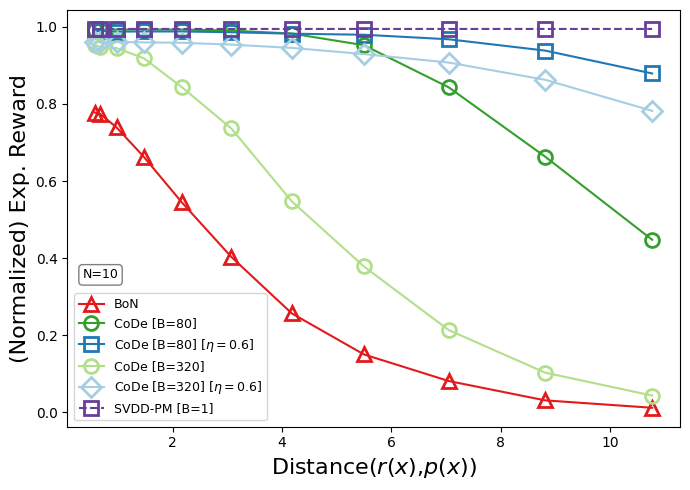

In [ ]:
import matplotlib

fig, ax = plt.subplots(figsize=(7,5))

# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

i = 0
# markers = ["o","s","d","^"]

# METHODS = list(results.keys())
# METHODS.remove('kls')
# print(METHODS)

#'CoDe (block=40)', 'C-CoDe (r=0.2, block=40)', 'CoDe (block=160)', 'C-CoDe (r=0.2, block=160)',
METHODS = ['bon', 'CoDe (block=80)', 'C-CoDe (r=0.2, block=80)',
            'CoDe (block=320)', 'C-CoDe (r=0.2, block=320)', 'SVDD-PM (block=1)'] # 'bon', 'C-BoN (r=0.8)', 
# METHODS = ['bon', 'CoDe (block=80)', 'C-CoDe (r=0.4, block=80)']


max_val = np.float64(0.04)
for key in METHODS:
    curr_max_val = np.max(results[key])
    if curr_max_val > max_val:
        max_val = curr_max_val

# print(type(max_val))

linestyles = {
    'bon': '-',
    # 'C-BoN': '-.',
    'CoDe (block=80)': '-',
    'C-CoDe (r=0.2, block=80)': '-',
    'CoDe (block=40)': '-',
    'C-CoDe (r=0.2, block=40)': '-',
    'CoDe (block=160)': '-',
    'C-CoDe (r=0.2, block=160)': '-',
    'CoDe (block=320)': '-',
    'C-CoDe (r=0.2, block=320)': '-',
    'SVDD-PM (block=1)': '--',
    # 'Universal Guidance (Bansal, 2024)': '-.',
    # 'DPS (Chung, 2023)': '-.'
}

label_map = {
    'bon': 'BoN',
    'C-BoN': 'C-BoN',
    'CoDe (block=40)': r'CoDe [B=40]',
    'C-CoDe (r=0.2, block=40)': r'CoDe [B=40] [$\eta=0.6$]',
    'CoDe (block=80)': r'CoDe [B=80]',
    'C-CoDe (r=0.2, block=80)': r'CoDe [B=80] [$\eta=0.6$]',
    'CoDe (block=160)': r'CoDe [B=160]',
    'C-CoDe (r=0.2, block=160)': r'CoDe [B=160] [$\eta=0.6$]',
    'CoDe (block=320)': r'CoDe [B=320]',
    'C-CoDe (r=0.2, block=320)': r'CoDe [B=320] [$\eta=0.6$]',
    'SVDD-PM (block=1)': r'SVDD-PM [B=1]',
}

for key in METHODS:
    print(key)
   
    # if key == 'bon':
    #     label = 'BoN'
    # elif 'C-BoN' in key:
    #     label = 'C-BoN'
    # elif 'CoDe' in key and 'C-CoDe' not in key:
    #     label = 'CoDe (Ours)'
    # elif 'C-CoDe' in key:
    #     label = 'C-CoDe (Ours)'

    kws = {"facecolor": "none", "linewidth": 1.5}

    if 'CoDe' in key and 'C-CoDe' not in key:
        sns.lineplot(x=results['kls'][:len(results[key])], y=results[key]/max_val, label=label_map[key], 
                    marker=markers[key], ax=ax, c=palette[key], linestyle=linestyles[key], 
                    markersize=10,fillstyle='none', markeredgecolor=None, markeredgewidth=2)
    else:
        sns.lineplot(x=results['kls'][:len(results[key])], y=results[key]/max_val, label=label_map[key], 
                    marker=markers[key], ax=ax, c=palette[key], linestyle=linestyles[key], 
                    markersize=10, fillstyle='none', markeredgecolor=None, markeredgewidth=2)
    i += 1

# h, l = ax.get_legend_handles_labels()
# kw = dict(ncol=4, loc="lower center", fontsize=16, frameon=False)    
# # leg1 = ax.legend(h[:2],l[:2], bbox_to_anchor=[0.5,1.08],**kw)
# # leg2 = ax.legend(h[2:],l[2:], bbox_to_anchor=[0.5,1.00],**kw)
# leg1 = ax.legend(h,l, bbox_to_anchor=[0.5,1.00],**kw)
# # ax.add_artist(leg1)

# plt.legend.set_title('N=10',prop={'size':'large'})
plt.legend(fontsize=9)
# fig.subplots_adjust(top=0.6)
plt.xlabel(r"Distance($r(x)$,$p(x)$)", fontsize=16)
plt.ylabel(f'{"(Normalized)" if normalize else ""} Exp. Reward',fontsize=16)
# plt.ylabel(r'$KL(\mu)$')

textstr = r'N=10'

# # these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.025, 0.38, textstr, transform=ax.transAxes, fontsize=9, # N's
        verticalalignment='top', bbox=props)

# plt.yscale('log')
plt.ylabel('Nr. of Samples (in log scale)', fontsize=16)
plt.tight_layout()
plt.savefig(f'{export_path}/nvals_r02_log_v2.png', dpi=300)
# plt.savefig(f'{export_path}/rewards_n10_B_abl.png', dpi=300)
plt.show()

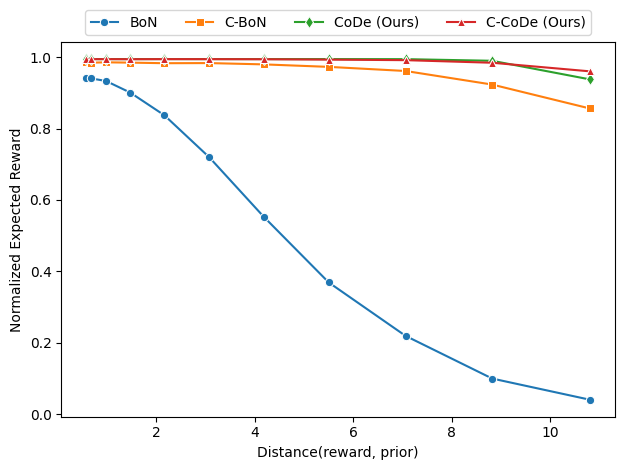

In [39]:
# sns.set_theme(style="darkgrid")
# sns.set_style('darkgrid', {'legend.frameon': True})
sns.color_palette("muted")

fig, ax = plt.subplots()

markers = ["o","s","d","^"]

METHODS = {
    'bon': 'BoN', 
    'C-BoN (r=0.2)': r'C-BoN', 
    'CoDe (block=80)': r'CoDe (Ours)', 
    'C-CoDe (r=0.2, block=80)': r'C-CoDe (Ours)'
}

i=0
for key in METHODS.keys():
    g = sns.lineplot(x=results['kls'][:len(results[key])], y=(results[key]/max_val), ax=ax, label=METHODS[key], marker=markers[i], legend=False)
    i += 1


# g.legend_.set_title(None)
# sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.25), ncol=2)

kw = dict(ncol=4, loc="lower center")    
plt.legend(bbox_to_anchor=[0.5, 1.00],**kw, facecolor='white')

plt.xlabel("Distance(reward, prior)")
plt.ylabel('Normalized Expected Reward')
# plt.yscale('log')
# plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()
# plt.savefig('rewards_n50.png', dpi=300)